## **การพยากรณ์การเช่าจักรยาน**

### **วัตถุประสงค์**

1.เพื่อสร้างตัวแบบอนุกรมเวลาที่สามารถใช้ในการทำนายการเช่าจักรยานได้แบบ Real-time อย่างมีประสิทธิภาพ

2.เพื่อเปรียบเทียบประสิทธิภาพในการพยากรณ์ของตัวแบบอนุกรมเวลาต่างๆ



* instant: record index
* dteday : date
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* hr : hour (0 to 23)
* holiday : weather day is holiday or not (extracted from [Web Link])
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit :
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#We use ray to run this in parallel
#Note: ผู้จัดทำ's PC has 2x32 threads CPU, you need to adjust the num_cpus based on your CPU
!pip install ray

In [ ]:
!pip -q install gdown
file_id = "1oOXFJnACP1VFJZ8ra9NThN0lznrwRjA_"
!gdown --id $file_id -O day.csv

C:\Users\Boonsoong\anaconda3\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oOXFJnACP1VFJZ8ra9NThN0lznrwRjA_
To: C:\Users\Boonsoong\day.csv

  0%|          | 0.00/57.6k [00:00<?, ?B/s]
100%|##########| 57.6k/57.6k [00:00<00:00, 1.49MB/s]


In [ ]:
#load data
df_day = pd.read_csv("day.csv")

#EDA

In [ ]:
df_day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


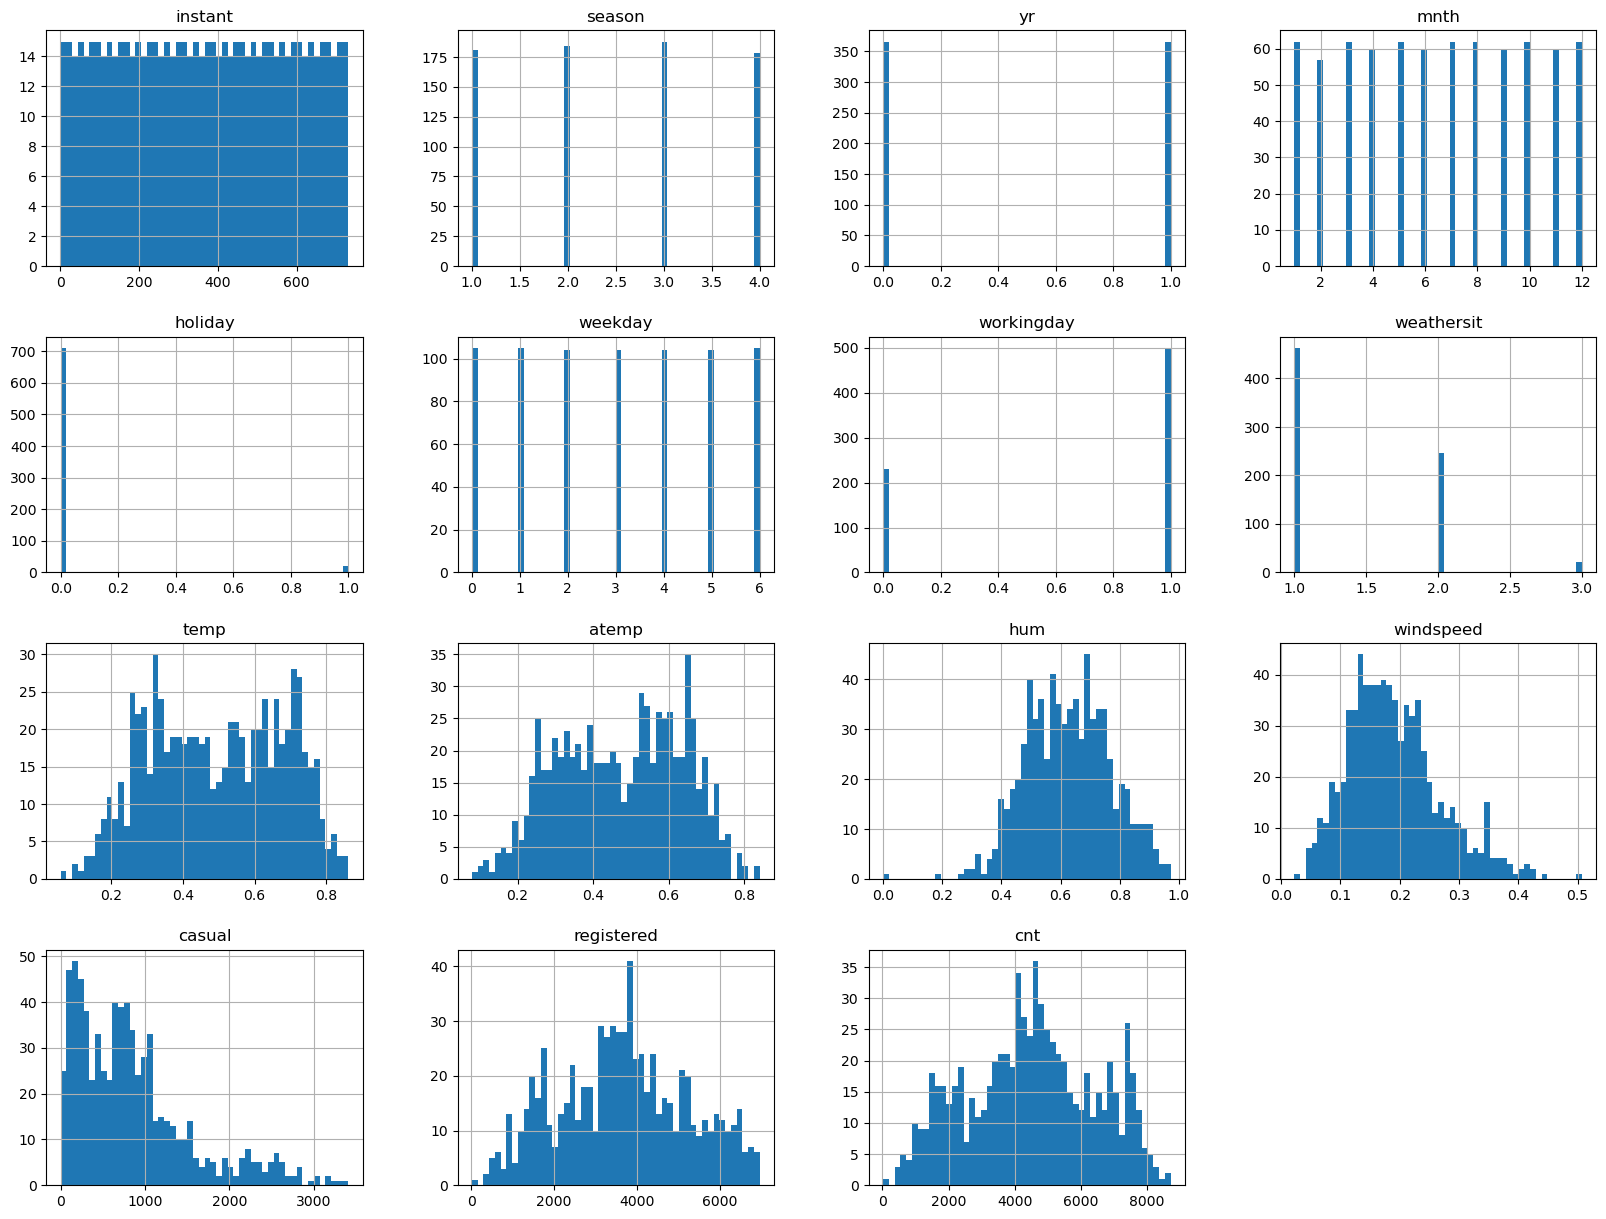

In [ ]:
df_day.hist(bins=50, figsize=(20,15))
plt.show()

# Outlier

In [ ]:
window = 30  # days
rolling_mean = df_day["cnt"].rolling(window=window, center=False).mean()
rolling_std = df_day["cnt"].rolling(window=window, center=False).std()

z_scores = (df_day["cnt"] - rolling_mean) / rolling_std

# Threshold for “outliers” in terms of local behaviour
threshold = 3  # 3 standard deviations
ts_outliers = df_day[(z_scores.abs() > threshold)]

print("Number of time-series outliers in cnt:", ts_outliers.shape[0])
ts_outliers[["cnt"]].head()

Number of time-series outliers in cnt: 5


,cnt
238,1115
301,627
477,1027
645,3510
667,22


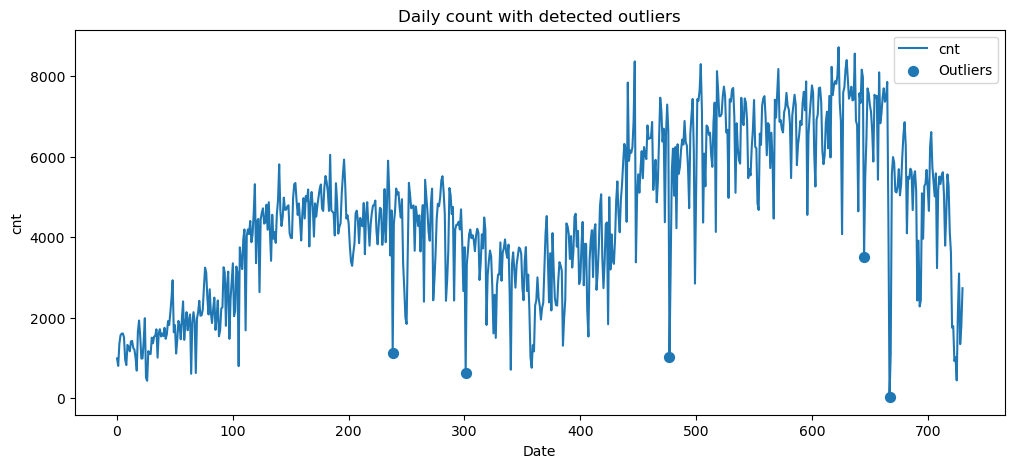

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_day.index, df_day["cnt"], label="cnt")

# highlight time-series outliers
plt.scatter(ts_outliers.index, ts_outliers["cnt"], marker="o", s=50, label="Outliers")

plt.title("Daily count with detected outliers")
plt.xlabel("Date")
plt.ylabel("cnt")
plt.legend()
plt.show()


# Visualizing Exog. Variable

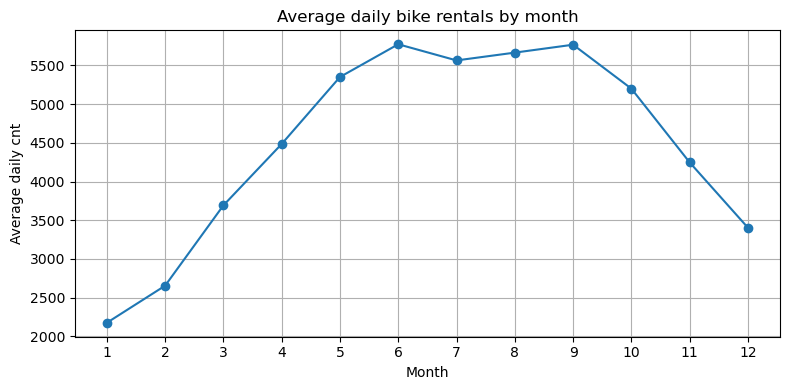

In [ ]:
monthly_avg = df_day.groupby("mnth")["cnt"].mean()

plt.figure(figsize=(8, 4))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Average daily cnt")
plt.title("Average daily bike rentals by month")
plt.grid(True)
plt.tight_layout()
plt.show()

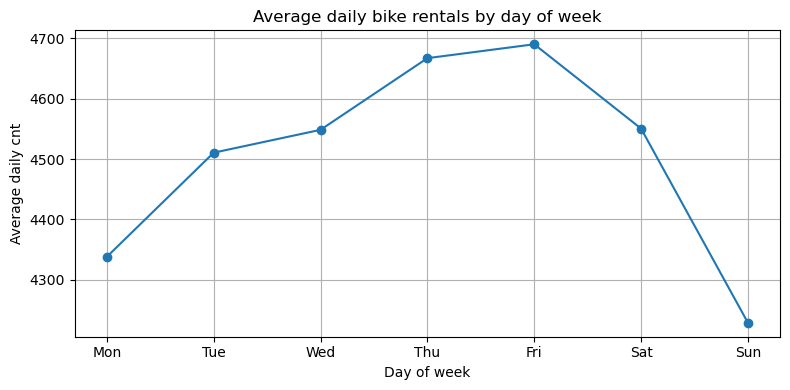

In [ ]:
weekday_map = {
    0: "Sun",
    1: "Mon",
    2: "Tue",
    3: "Wed",
    4: "Thu",
    5: "Fri",
    6: "Sat",
}

# Map numeric weekday to names and keep correct order
df_day["weekday_name"] = df_day["weekday"].map(weekday_map)
order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df_day["weekday_name"] = pd.Categorical(df_day["weekday_name"],
                                        categories=order,
                                        ordered=True)

dow_avg = df_day.groupby("weekday_name")["cnt"].mean()

plt.figure(figsize=(8, 4))
plt.plot(dow_avg.index, dow_avg.values, marker="o")
plt.xlabel("Day of week")
plt.ylabel("Average daily cnt")
plt.title("Average daily bike rentals by day of week")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

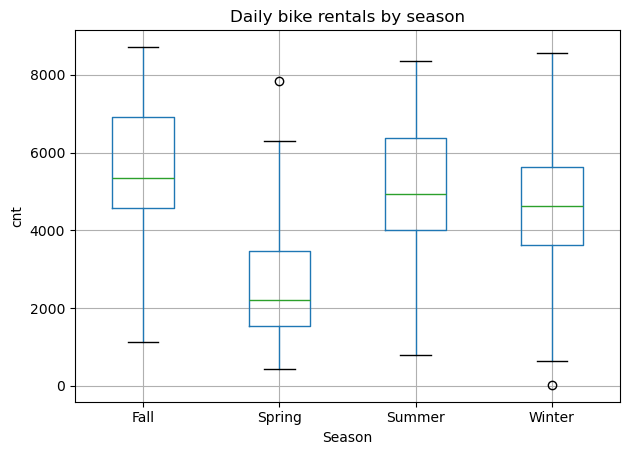

In [ ]:
# --- Boxplot of cnt by season ---

season_map = {
    1: "Spring",
    2: "Summer",
    3: "Fall",
    4: "Winter",
}
df_day["season_name"] = df_day["season"].map(season_map)

plt.figure(figsize=(8, 4))
df_day.boxplot(column="cnt", by="season_name")
plt.xlabel("Season")
plt.ylabel("cnt")
plt.title("Daily bike rentals by season")
plt.suptitle("")  # remove automatic pandas title
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

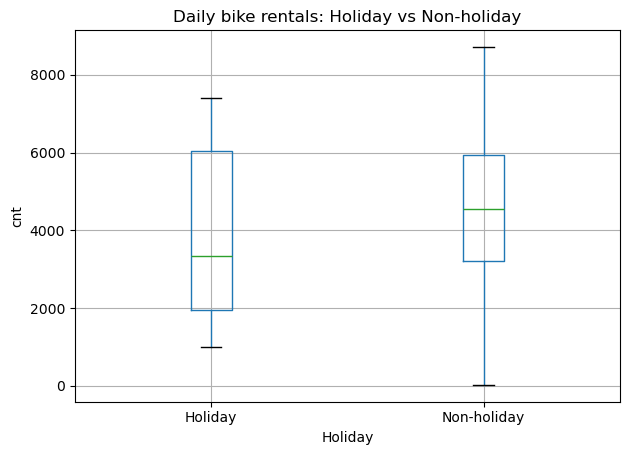

<Figure size 600x400 with 0 Axes>

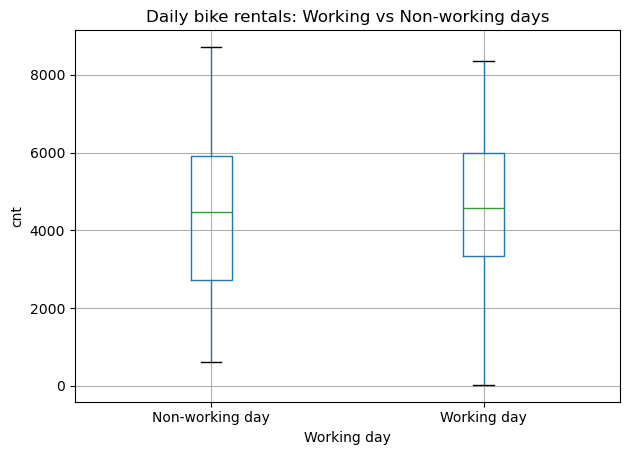

In [ ]:
# --- Boxplot of cnt by holiday ---

df_day["holiday_flag"] = df_day["holiday"].map({0: "Non-holiday", 1: "Holiday"})

plt.figure(figsize=(6, 4))
df_day.boxplot(column="cnt", by="holiday_flag")
plt.xlabel("Holiday")
plt.ylabel("cnt")
plt.title("Daily bike rentals: Holiday vs Non-holiday")
plt.suptitle("")
plt.tight_layout()
plt.show()


# --- Boxplot of cnt by workingday ---

df_day["workingday_flag"] = df_day["workingday"].map({0: "Non-working day",
                                                      1: "Working day"})

plt.figure(figsize=(6, 4))
df_day.boxplot(column="cnt", by="workingday_flag")
plt.xlabel("Working day")
plt.ylabel("cnt")
plt.title("Daily bike rentals: Working vs Non-working days")
plt.suptitle("")
plt.tight_layout()
plt.show()


<Figure size 900x400 with 0 Axes>

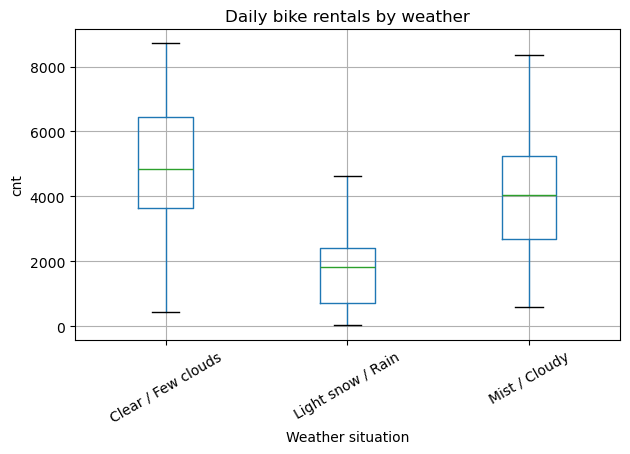

In [ ]:
# --- Boxplot of cnt by weather situation ---

weather_map = {
    1: "Clear / Few clouds",
    2: "Mist / Cloudy",
    3: "Light snow / Rain",
    4: "Heavy rain / Snow",
}
df_day["weather_name"] = df_day["weathersit"].map(weather_map)

plt.figure(figsize=(9, 4))
df_day.boxplot(column="cnt", by="weather_name", rot=30)
plt.xlabel("Weather situation")
plt.ylabel("cnt")
plt.title("Daily bike rentals by weather")
plt.suptitle("")
plt.tight_layout()
plt.show()


In [ ]:
#0/1 -> exogenous(บอกในmodel)
#1)yr 2)holiday(แปลง->ลบออก) 3)working day
#Categorical -> one-hot encoding
#1)season 2)mnth 3)weekday(แปลง->ลบออก) 4)weathersit

#Feature Engineering

In [ ]:
#one-hot encoding
df_day = pd.get_dummies(df_day, columns=['season'], prefix='season', drop_first=True)
df_day = pd.get_dummies(df_day, columns=['mnth'], prefix='month', drop_first=True)
df_day = pd.get_dummies(df_day, columns=['weathersit'], prefix='weather', drop_first=True)

In [ ]:
df_day['holiday_prev'] = df_day['holiday'].shift(1)
df_day['holiday_next'] = df_day['holiday'].shift(-1)
df_day['weekday_prev'] = df_day['weekday'].shift(1)
df_day['weekday_next'] = df_day['weekday'].shift(-1)
#Feature ก่อน/หลังวันหยุด
df_day['is_before_holiday'] = (df_day['holiday_next'] == 1).astype(int)
df_day['is_after_holiday'] = (df_day['holiday_prev'] == 1).astype(int)
#Feature ก่อน/หลังเสาร์-อาทิตย์
df_day['is_before_weekend'] = (df_day['weekday_next'].isin([0, 6])).astype(int)
df_day['is_after_weekend'] = (df_day['weekday_prev'].isin([0, 6])).astype(int)
#ลบค่าแถวแรก/สุดท้าย
df_day = df_day.dropna(subset=['holiday_prev', 'holiday_next', 'weekday_prev', 'weekday_next']).reset_index(drop=True)

In [ ]:
# ลบ holiday และ weekday สัมพันธ์ทางlogic กับ working day
df_day = df_day.drop(columns=['holiday', 'weekday'])

In [ ]:
#ห้ามใช้casual,registered -> cnt = casual + registered
df_day['casual_lag1'] = df_day['casual'].shift(1)
df_day['registered_lag1'] = df_day['registered'].shift(1)
df_day = df_day.dropna(subset=['casual_lag1', 'registered_lag1']).reset_index(drop=True)

In [ ]:
#Check missing value
print(df_day.isnull().sum())
len(df_day.columns)
#ไม่มี missing value

instant              0
dteday               0
yr                   0
workingday           0
temp                 0
atemp                0
hum                  0
windspeed            0
casual               0
registered           0
cnt                  0
weekday_name         0
season_name          0
holiday_flag         0
workingday_flag      0
weather_name         0
season_2             0
season_3             0
season_4             0
month_2              0
month_3              0
month_4              0
month_5              0
month_6              0
month_7              0
month_8              0
month_9              0
month_10             0
month_11             0
month_12             0
weather_2            0
weather_3            0
holiday_prev         0
holiday_next         0
weekday_prev         0
weekday_next         0
is_before_holiday    0
is_after_holiday     0
is_before_weekend    0
is_after_weekend     0
casual_lag1          0
registered_lag1      0
dtype: int64


42

#Check correlation

In [ ]:
import seaborn as sns

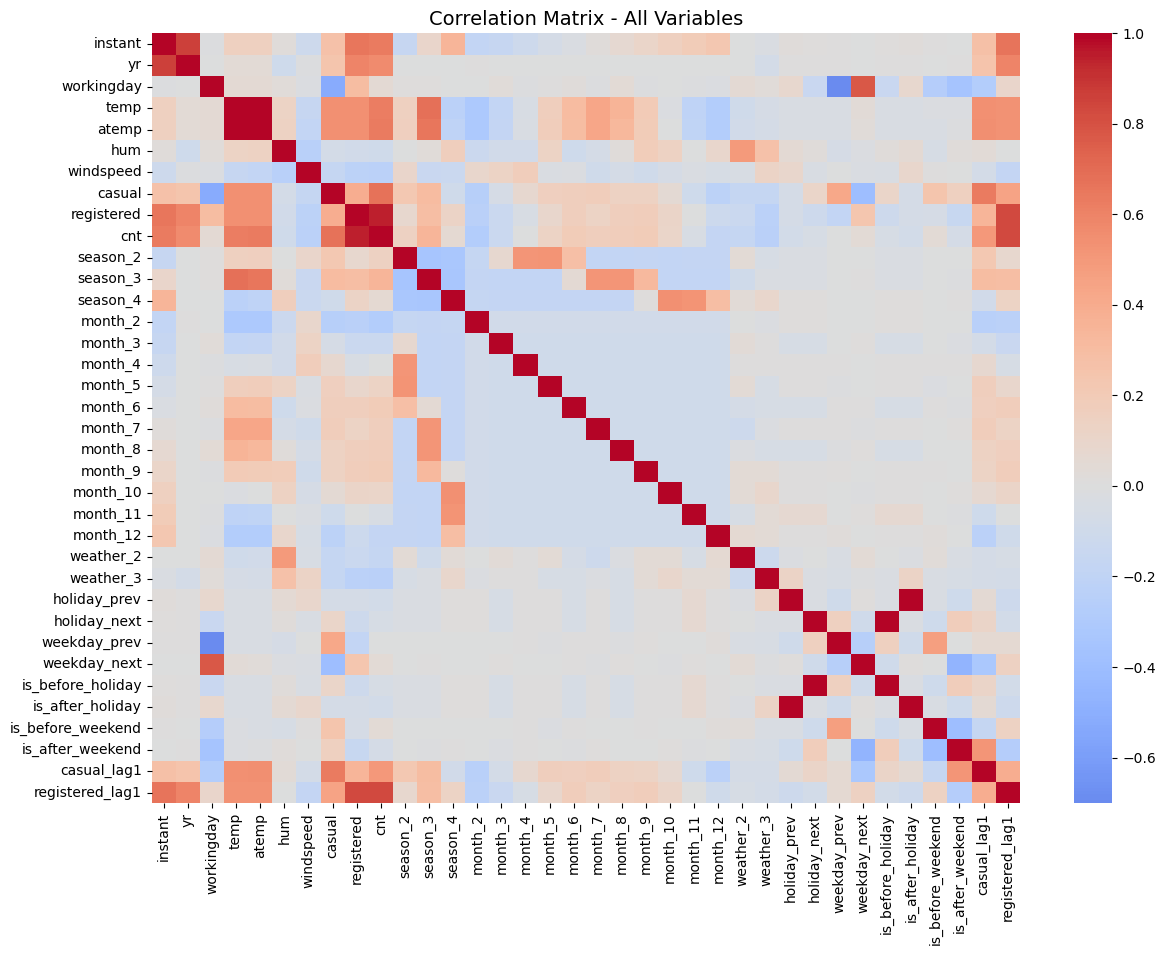

In [ ]:
#Correlation Matrix
plt.figure(figsize=(14, 10))
corr_all = df_day.corr(numeric_only=True)
sns.heatmap(corr_all, cmap='coolwarm', annot=False, center=0)
plt.title('Correlation Matrix - All Variables', fontsize=14)
plt.show()

In [ ]:
#Correlation Matrix
corr_matrix = df_day.corr(numeric_only=True)

#เก็บคู่ตัวแปรที่ correlation > 0.8
high_corr_pairs = (
    corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))  # เอา diagonal ออก (ไม่เอา corr=1 กับตัวเอง)
    .stack()  # แปลงเป็น long format
    .reset_index()
)
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

#กรองเฉพาะคู่ที่มี correlation > 0.8 หรือ < -0.8
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Correlation'].abs() > 0.8)
].sort_values(by='Correlation', ascending=False).reset_index(drop=True)

pd.set_option('display.max_rows', None)
high_corr_pairs


,Variable 1,Variable 2,Correlation
0,holiday_prev,is_after_holiday,1.000000
1,holiday_next,is_before_holiday,1.000000
2,is_before_holiday,holiday_next,1.000000
3,is_after_holiday,holiday_prev,1.000000
4,temp,atemp,0.991677
5,atemp,temp,0.991677
6,registered,cnt,0.944923
7,cnt,registered,0.944923
8,instant,yr,0.866023
9,yr,instant,0.866023


In [ ]:
#drop feature correlation > 0.8
df_day = df_day.drop(columns=['holiday_prev'])
df_day = df_day.drop(columns=['holiday_next'])

df_day['temp_mean'] = (df_day['temp'] + df_day['atemp']) / 2
df_day = df_day.drop(columns=['temp', 'atemp'])

df_day = df_day.drop(columns=['registered','casual'])

df_day = df_day.drop(columns=['instant'])

In [ ]:
exog_vars = [
    'workingday',
    'temp_mean', 'hum', 'windspeed',
    'season_2', 'season_3', 'season_4',
    'month_2', 'month_3', 'month_4', 'month_5',
    'month_6', 'month_7', 'month_8', 'month_9',
    'month_10', 'month_11', 'month_12',
    'weather_2', 'weather_3',
    'is_before_holiday', 'is_after_holiday',
    'is_before_weekend', 'is_after_weekend',
    'casual_lag1', 'registered_lag1'
]

len(exog_vars)


26

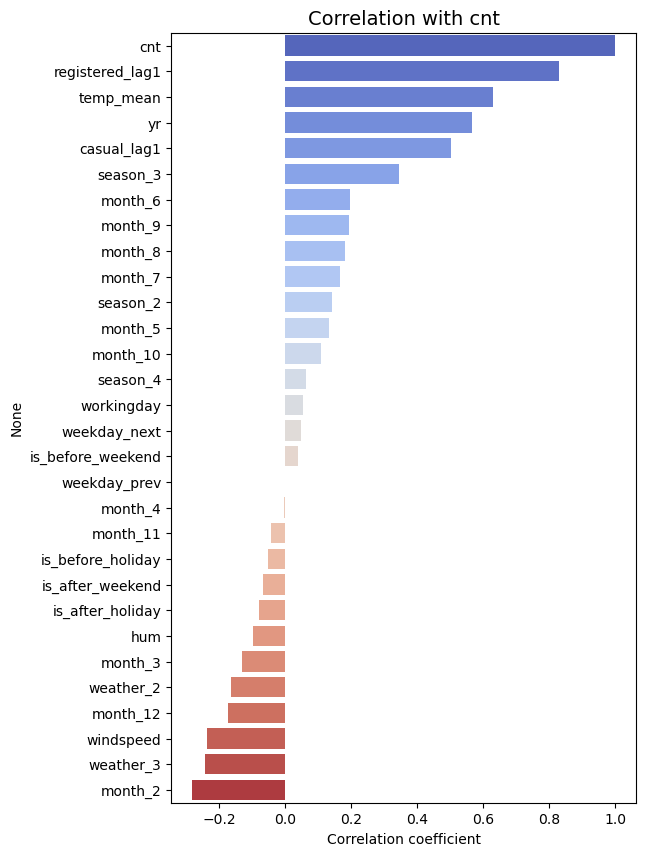

cnt                  1.000000
registered_lag1      0.830921
temp_mean            0.629602
yr                   0.567050
casual_lag1          0.502499
season_3             0.344828
month_6              0.195041
month_9              0.194132
month_8              0.181492
month_7              0.165562
season_2             0.143364
month_5              0.131736
month_10             0.107929
season_4             0.062347
workingday           0.054955
weekday_next         0.048951
is_before_weekend    0.039613
weekday_prev         0.000542
month_4             -0.004941
month_11            -0.041865
is_before_holiday   -0.053219
is_after_weekend    -0.068514
is_after_holiday    -0.079362
hum                 -0.097378
month_3             -0.130374
weather_2           -0.165497
month_12            -0.172698
windspeed           -0.235540
weather_3           -0.242373
month_2             -0.281181
Name: cnt, dtype: float64


In [ ]:
#Correlation เทียบ target
corr_all = df_day.corr(numeric_only=True)
corr_target = corr_all['cnt'].sort_values(ascending=False)
plt.figure(figsize=(6, 10))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title('Correlation with cnt', fontsize=14)
plt.xlabel('Correlation coefficient')
plt.show()

print(corr_target)

# Granger causality test

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

feature_cols = [
    'workingday', 'hum', 'windspeed', 'season_2',
    'season_3', 'season_4', 'weather_2', 'weather_3',
    'weekday_prev', 'weekday_next',
    'is_before_holiday', 'is_after_holiday', 'is_before_weekend',
    'is_after_weekend', 'casual_lag1', 'registered_lag1', 'temp_mean'
]

# Extract target + exogenous
df_day['y_log'] = np.log1p(df_day['cnt'].astype(float))
data_gc = df_day[['y_log'] + feature_cols].copy()

# Convert bool columns to int (0/1)
bool_cols = data_gc.select_dtypes(include=['bool']).columns
data_gc[bool_cols] = data_gc[bool_cols].astype(int)

# Drop rows with NaN (e.g. from lags)
data_gc = data_gc.dropna()


In [ ]:
def granger_causality_for_exog(data, target_col, exog_cols, maxlag=7, test='ssr_chi2test'):
    """
    Run Granger causality test for each exogenous variable:
      H0: exog does NOT Granger-cause target.
    data      : DataFrame with target and exog
    target_col: name of target column (string)
    exog_cols : list of exogenous column names
    maxlag    : maximum lag to test
    test      : which test in grangercausalitytests result dict to use
                (e.g. 'ssr_chi2test', 'ssr_ftest', 'lrtest', 'params_ftest')
    Returns: DataFrame with min p-value and best lag per exog.
    """
    results = []

    for col in exog_cols:
        # Granger test expects 2-column array [target, exog]
        # To test if exog -> target, target must be first column.
        subset = data[[target_col, col]].dropna()

        if subset.shape[0] <= maxlag + 1:
            # Not enough data points
            results.append({
                'exog': col,
                'best_lag': np.nan,
                'min_pvalue': np.nan
            })
            continue

        try:
            gc_res = grangercausalitytests(subset, maxlag=maxlag, verbose=False)

            pvalues = []
            for lag in range(1, maxlag + 1):
                # gc_res[lag][0][test] is (stat, pvalue, df_denom, df_num) or similar
                stat, pval, *_ = gc_res[lag][0][test]
                pvalues.append((lag, pval))

            # pick lag with smallest p-value
            best_lag, min_pval = min(pvalues, key=lambda x: x[1])

            results.append({
                'exog': col,
                'best_lag': best_lag,
                'min_pvalue': min_pval
            })

        except Exception as e:
            print(f"Granger test failed for {col}: {e}")
            results.append({
                'exog': col,
                'best_lag': np.nan,
                'min_pvalue': np.nan
            })

    return pd.DataFrame(results)


In [ ]:
gc_results = granger_causality_for_exog(
    data=data_gc,
    target_col='y_log',
    exog_cols=feature_cols,
    maxlag=7,
    test='ssr_chi2test'
)

print(gc_results.sort_values('min_pvalue'))

                 exog  best_lag    min_pvalue
15    registered_lag1         1  1.172801e-13
16          temp_mean         1  1.761270e-08
7           weather_3         2  8.923834e-07
14        casual_lag1         2  4.162780e-06
5            season_4         6  1.485062e-04
1                 hum         1  1.590110e-04
4            season_3         1  6.568481e-04
0          workingday         2  4.098952e-03
2           windspeed         2  4.227675e-03
12  is_before_weekend         2  9.151185e-03
13   is_after_weekend         4  1.392364e-02
10  is_before_holiday         4  2.018836e-02
8        weekday_prev         3  3.363765e-02
9        weekday_next         3  4.640632e-02
3            season_2         1  7.540061e-02
11   is_after_holiday         1  1.677086e-01
6           weather_2         5  4.493776e-01


#Identifying Trends and Seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

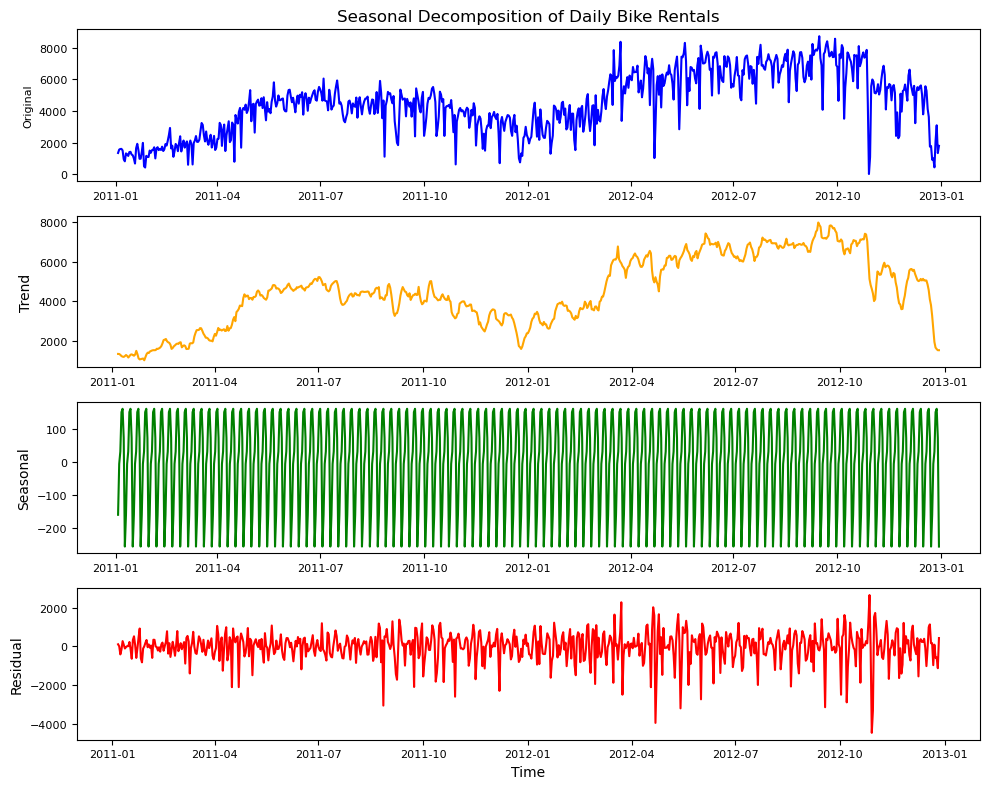

In [ ]:
# แปลงคอลัมน์วัน datetime เป็น index
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_day = df_day.set_index('dteday').sort_index()

# Select target
timeseries = df_day['cnt']

# Sesonal decomposition
result = seasonal_decompose(timeseries, model='additive', period=7)

# Plot Components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# Original
ax1.plot(timeseries, color='blue')
ax1.set_ylabel('Original', fontsize=8)
ax1.set_title('Seasonal Decomposition of Daily Bike Rentals', fontsize=12)

# Trend
ax2.plot(result.trend, color='orange')
ax2.set_ylabel('Trend', fontsize=10)

# Seasonal
ax3.plot(result.seasonal, color='green')
ax3.set_ylabel('Seasonal', fontsize=10)

# Residual
ax4.plot(result.resid, color='red')
ax4.set_xlabel('Time', fontsize=10)
ax4.set_ylabel('Residual', fontsize=10)

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

#Additive and Multiplicative Decomposition

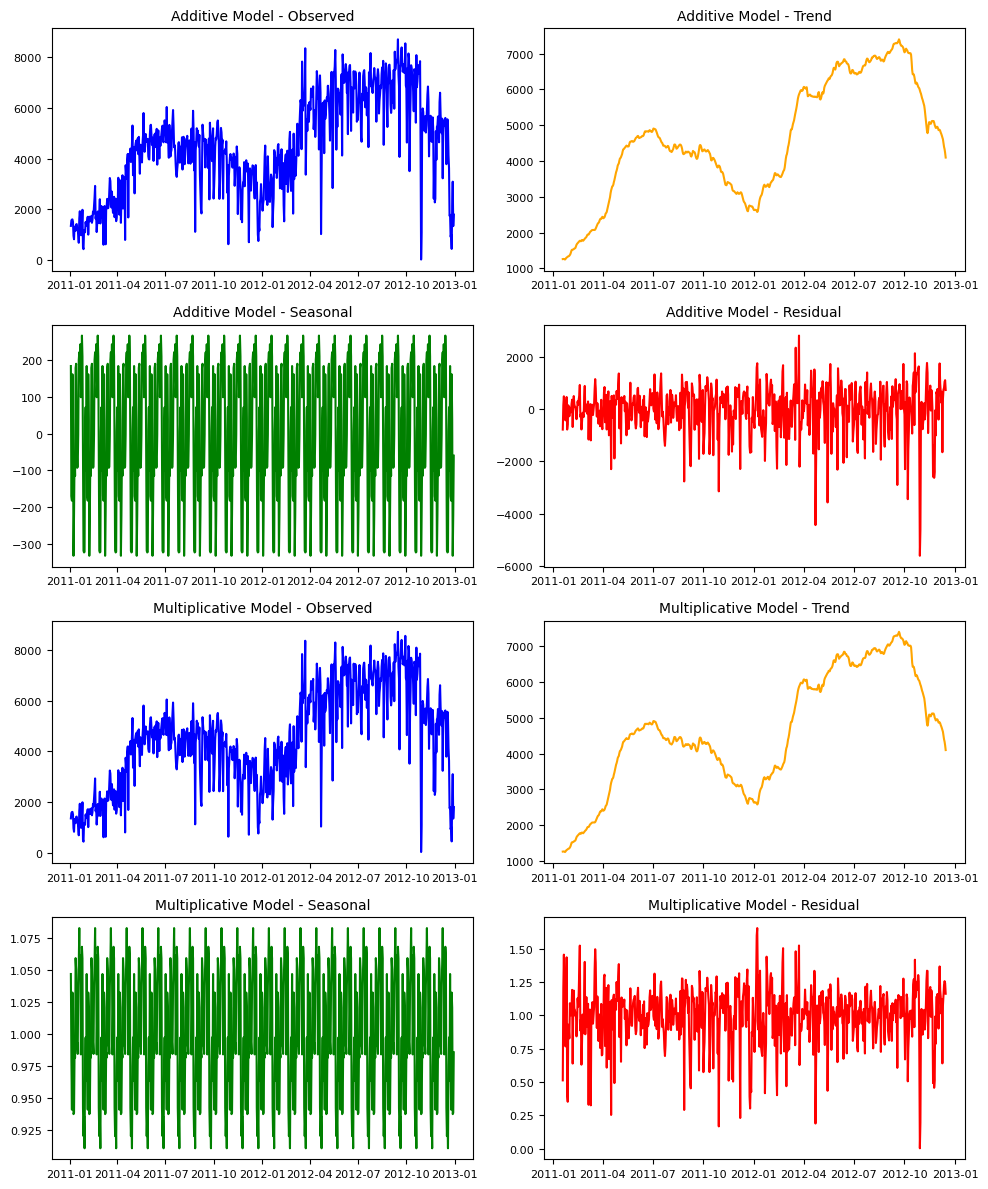

In [ ]:
# Addictive model
result_add = seasonal_decompose(timeseries, model='additive', period=30)

# Multiplicative model
# ทำให้ข้อมูลเป็นบวกทั้งหมด (จำเป็นสำหรับ multiplicative)
if (timeseries <= 0).any():
    timeseries = timeseries - timeseries.min() + 1

result_mul = seasonal_decompose(timeseries, model='multiplicative', period=30)

# Plot both model side-by-side
fig, axes = plt.subplots(4, 2, figsize=(10, 12))

# Additive
axes[0, 0].plot(result_add.observed, color='blue')
axes[0, 0].set_title('Additive Model - Observed', fontsize=10)

axes[0, 1].plot(result_add.trend, color='orange')
axes[0, 1].set_title('Additive Model - Trend', fontsize=10)

axes[1, 0].plot(result_add.seasonal, color='green')
axes[1, 0].set_title('Additive Model - Seasonal', fontsize=10)

axes[1, 1].plot(result_add.resid, color='red')
axes[1, 1].set_title('Additive Model - Residual', fontsize=10)

# Multiplicative
axes[2, 0].plot(result_mul.observed, color='blue')
axes[2, 0].set_title('Multiplicative Model - Observed', fontsize=10)

axes[2, 1].plot(result_mul.trend, color='orange')
axes[2, 1].set_title('Multiplicative Model - Trend', fontsize=10)

axes[3, 0].plot(result_mul.seasonal, color='green')
axes[3, 0].set_title('Multiplicative Model - Seasonal', fontsize=10)

axes[3, 1].plot(result_mul.resid, color='red')
axes[3, 1].set_title('Multiplicative Model - Residual', fontsize=10)

# ปรับขนาด label และ layout
for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

# Log transformation

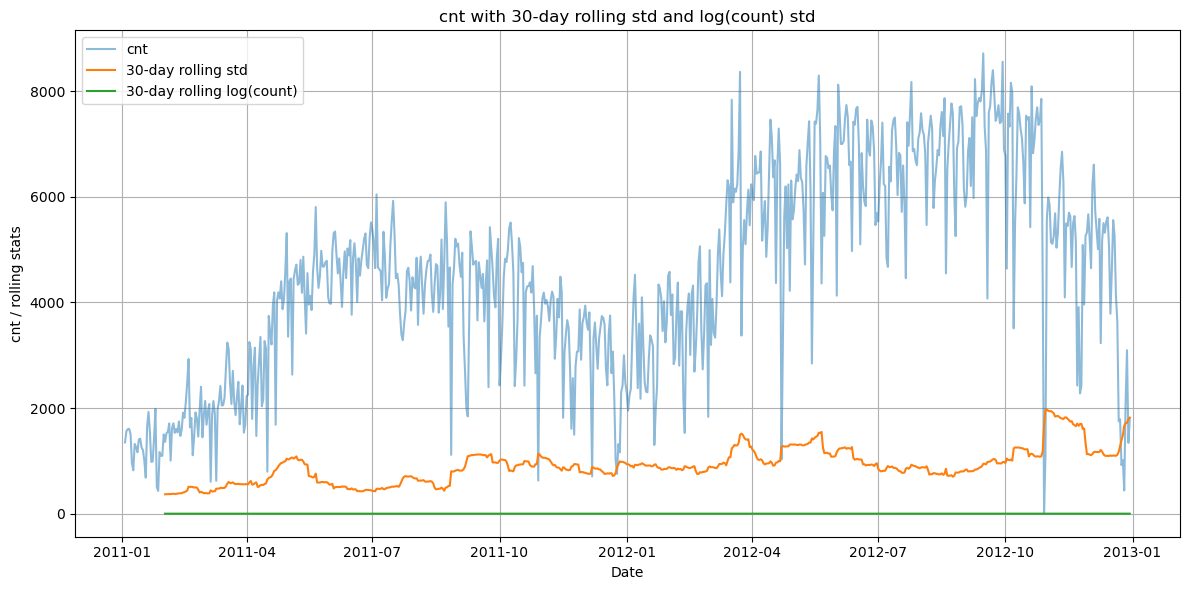

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss

y = df_day["cnt"]


window = 30  # 30 days = about a month

rolling_std = y.rolling(window=window).std()
rolling_log = np.log1p(y).rolling(window=window).std()

plt.figure(figsize=(12, 6))

plt.plot(y.index, y, label="cnt", alpha=0.5)
plt.plot(rolling_std.index, rolling_std, label=f"{window}-day rolling std")
plt.plot(rolling_log.index, rolling_log, label=f"{window}-day rolling log(count)")

plt.title(f"cnt with {window}-day rolling std and log(count) std")
plt.xlabel("Date")
plt.ylabel("cnt / rolling stats")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

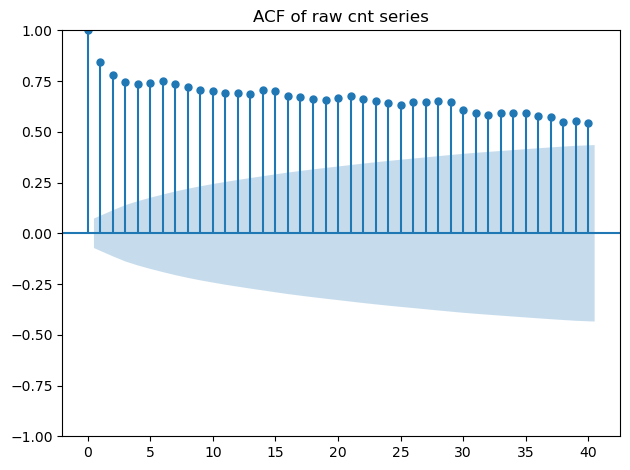

In [ ]:

plt.figure(figsize=(8, 4))
plot_acf(y.dropna(), lags=40)
plt.title("ACF of raw cnt series")
plt.tight_layout()
plt.show()

y_log = np.log1p(y)

# Stationarity

In [ ]:
def adf_test(series, name=""):
    """Augmented Dickey–Fuller test"""
    result = adfuller(series.dropna(), autolag="AIC")
    labels = ['ADF statistic', 'p-value', '# lags used', '# observations']
    out = dict(zip(labels, result[:4]))
    print(f"\nADF Test on '{name}'")
    print("-" * 40)
    for key, val in out.items():
        print(f"{key}: {val}")
    if out['p-value'] < 0.05:
        print("=> Reject H0 (unit root) → series looks STATIONARY by ADF.")
    else:
        print("=> Fail to reject H0 → series looks NON-stationary by ADF.")


def kpss_test(series, name=""):
    """KPSS test (null = stationary)"""
    statistic, p_value, n_lags, crit_vals = kpss(series.dropna(), regression="c", nlags="auto")
    print(f"\nKPSS Test on '{name}'")
    print("-" * 40)
    print(f"KPSS statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"# lags: {n_lags}")
    if p_value < 0.05:
        print("=> Reject H0 (stationarity) → series looks NON-stationary by KPSS.")
    else:
        print("=> Fail to reject H0 → series looks STATIONARY by KPSS.")

adf_test(y_log, name="logcnt (level)")
kpss_test(y_log, name="logcnt (level)")



ADF Test on 'logcnt (level)'
----------------------------------------
ADF statistic: -2.4635805261519326
p-value: 0.12458885908917056
# lags used: 16
# observations: 711
=> Fail to reject H0 → series looks NON-stationary by ADF.

KPSS Test on 'logcnt (level)'
----------------------------------------
KPSS statistic: 2.0203454176449465
p-value: 0.01
# lags: 16
=> Reject H0 (stationarity) → series looks NON-stationary by KPSS.


In [ ]:
y_log_diff = y_log.diff().dropna()

adf_test(y_log_diff, name="logcnt (level)")
kpss_test(y_log_diff, name="logcnt (level)")


ADF Test on 'logcnt (level)'
----------------------------------------
ADF statistic: -10.210352487145093
p-value: 5.659695413526321e-18
# lags used: 15
# observations: 711
=> Reject H0 (unit root) → series looks STATIONARY by ADF.

KPSS Test on 'logcnt (level)'
----------------------------------------
KPSS statistic: 0.24216461814335724
p-value: 0.1
# lags: 89
=> Fail to reject H0 → series looks STATIONARY by KPSS.


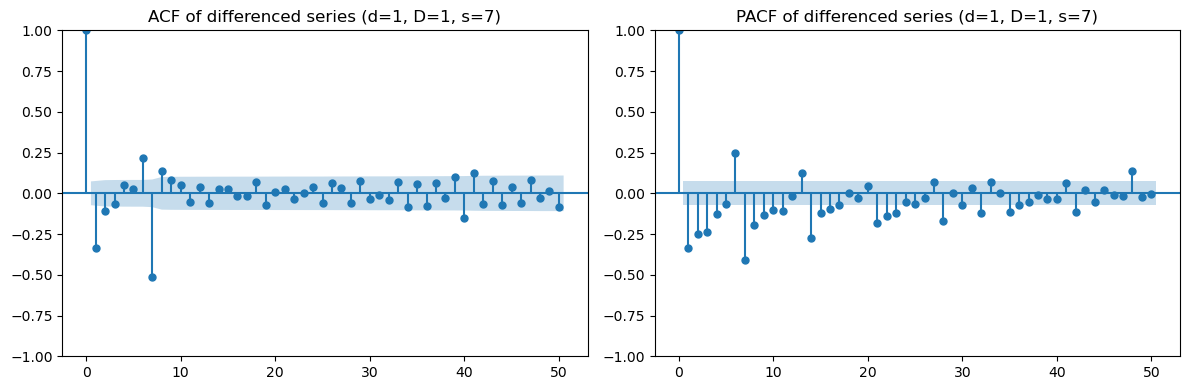

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# First non-seasonal diff (d=1), then seasonal diff D=1 with period s
y_tilde = y_log.diff().diff(7).dropna()


# --- Step 2: plot ACF and PACF of y_tilde ---

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_tilde, lags=50, ax=axes[0])
axes[0].set_title("ACF of differenced series (d=1, D=1, s=7)")

plot_pacf(y_tilde, lags=50, ax=axes[1], method="ywm")  # method avoids some warnings
axes[1].set_title("PACF of differenced series (d=1, D=1, s=7)")

plt.tight_layout()
plt.show()


#SARIMA

##1.Prepareing

In [ ]:
# This is the same data as before, we (ผู้จัดทำ) was scared that the data will be tampered whilst coding so we decided to always download again
file_id = "1yESKCiY_PmrHn6S9kGkaEvnNWfowzL7K"
!gdown --id $file_id -O df_day.csv

import pandas as pd
df = pd.read_csv("df_day.csv")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import ray


## 2.เตรียมข้อมูลและ Split data

In [ ]:
#Basic time-series prep ---
df['y_log'] = np.log1p(df['cnt'].astype(float))

y_all   = df['y_log'].dropna()
cnt_all = df['cnt'].loc[y_all.index]

n_total = len(y_all)

#70/30 split (train+CV vs final test) ---
trainval_size = int(n_total * 0.7)

y_trainval   = y_all.iloc[:trainval_size]
y_test       = y_all.iloc[trainval_size:]
cnt_trainval = cnt_all.iloc[:trainval_size]
cnt_test     = cnt_all.iloc[trainval_size:]

print("Train+CV range:", y_trainval.index.min(), "to", y_trainval.index.max())
print("Test range    :", y_test.index.min(),      "to", y_test.index.max())
print("Train+CV len  :", len(y_trainval), " Test len:", len(y_test))


Train+CV range: 2011-01-03 00:00:00 to 2012-05-25 00:00:00
Test range    : 2012-05-26 00:00:00 to 2012-12-30 00:00:00
Train+CV len  : 509  Test len: 219


In [ ]:
def make_expanding_splits(n_obs, n_splits=5):
    """
    Create expanding-window CV splits:
    Returns list of tuples: (train_start, train_end, val_start, val_end)
    indices are 0-based positions within y_trainval.
    """
    splits = []
    fold_size = n_obs // (n_splits + 1)  # size of each block

    for k in range(n_splits):
        train_end = fold_size * (k + 1) - 1          # growing train
        val_start = train_end + 1
        val_end   = val_start + fold_size - 1

        if val_end >= n_obs:
            break

        splits.append((0, train_end, val_start, val_end))

    return splits

n_obs_trainval = len(y_trainval)
cv_splits = make_expanding_splits(n_obs_trainval, n_splits=5)

print("CV splits (train_start, train_end, val_start, val_end):")
for s in cv_splits:
    print(s, "=>",
          f"train_len={s[1]-s[0]+1}, val_len={s[3]-s[2]+1}")


CV splits (train_start, train_end, val_start, val_end):
(0, 83, 84, 167) => train_len=84, val_len=84
(0, 167, 168, 251) => train_len=168, val_len=84
(0, 251, 252, 335) => train_len=252, val_len=84
(0, 335, 336, 419) => train_len=336, val_len=84
(0, 419, 420, 503) => train_len=420, val_len=84


In [ ]:
d, D, m = 1, 1, 7

p = q = range(0, 6)   # 0..6
P = Q = range(0, 6)   # 0..6

param_grid = []
for order in itertools.product(p, [d], q):
    for s_order in itertools.product(P, [D], Q, [m]):
        p_, _, q_     = order
        P_, _, Q_, _  = s_order

        param_grid.append((order, s_order))

print(f"Total candidate models: {len(param_grid)}")


Total candidate models: 1296


In [ ]:
ray.shutdown()
ray.init(num_cpus=64)  # or just ray.init()

2025-11-17 01:32:15,712	INFO worker.py:1788 -- Started a local Ray instance.


Python version:,3.12.4
Ray version:,2.32.0


## 3.Evaluate sarima

In [ ]:
@ray.remote
def evaluate_sarima_cv_remote(order, seasonal_order, y_array, cnt_array, cv_splits):
    """
    Expanding-window CV RMSE for a single SARIMA(order, seasonal_order).
    y_array  : log-transformed series (train+CV block)
    cnt_array: original counts (train+CV block)
    cv_splits: list of (train_start, train_end, val_start, val_end)
    """
    try:
        y_array   = np.asarray(y_array,   dtype="float64")
        cnt_array = np.asarray(cnt_array, dtype="float64")

        rmses = []

        for (tr_start, tr_end, val_start, val_end) in cv_splits:
            # Training subset (expanding window)
            endog_train = np.ascontiguousarray(y_array[tr_start:tr_end+1])

            # Fit SARIMA on this training fold
            model = SARIMAX(
                endog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = model.fit(disp=False)

            # Forecast into the validation window
            n_val = val_end - val_start + 1
            forecast_res = results.get_forecast(steps=n_val)
            y_pred_log = forecast_res.predicted_mean

            # Back-transform
            y_pred = np.expm1(y_pred_log)

            # True values in original scale
            cnt_true = cnt_array[val_start:val_end+1]

            mse  = mean_squared_error(cnt_true, y_pred)
            rmse = np.sqrt(mse)
            rmses.append(rmse)

        cv_rmse = float(np.mean(rmses))

        # cv_rmse is enough.
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "cv_rmse": cv_rmse,
            "error": None,
        }

    except Exception as e:
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "cv_rmse": np.inf,
            "error": str(e),
        }


In [ ]:
y_trainval_array   = y_trainval.values
cnt_trainval_array = cnt_trainval.values

futures = [
    evaluate_sarima_cv_remote.remote(order, s_order,
                                     y_trainval_array,
                                     cnt_trainval_array,
                                     cv_splits)
    for (order, s_order) in param_grid
]

results_list = []
num_completed = 0
total = len(futures)

while futures:
    done, futures = ray.wait(futures, num_returns=1)
    res = ray.get(done[0])
    results_list.append(res)
    num_completed += 1

    # Progress every 50 models
    if num_completed % 50 == 0 or num_completed == total:
        ok_so_far = [r for r in results_list
                     if r["error"] is None and np.isfinite(r["cv_rmse"])]
        if ok_so_far:
            best_so_far = min(ok_so_far, key=lambda r: r["cv_rmse"])
            print(f"[Progress] {num_completed}/{total} models done. "
                  f"Best CV RMSE so far: {best_so_far['cv_rmse']:.3f} "
                  f"at {best_so_far['order']} x {best_so_far['seasonal_order']}")
        else:
            print(f"[Progress] {num_completed}/{total} models done, "
                  "no valid models yet.")


(evaluate_sarima_cv_remote pid=55700) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=55700)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=94544) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
(evaluate_sarima_cv_remote pid=94544)   warnings.warn("Maximum Likelihood optimization failed to "
(evaluate_sarima_cv_remote pid=97052) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=83936) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to 

[Progress] 50/1296 models done. Best CV RMSE so far: 1261.180 at (0, 1, 1) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=71412) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=64428) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=64428)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=48452) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 9x across cluster]
(evaluate_sarima_cv_remote pid=48452)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 9x across cluster]
(evaluate_sarima_cv_remote pid=68700) C:\Users\Bo

[Progress] 100/1296 models done. Best CV RMSE so far: 1226.872 at (0, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=71412) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=71412)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=67196) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=48852) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 16x across cluster]
(evaluate_sarima_cv_remote pid=48852)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 16x across cluster]
(evaluate_sarima_cv_remote pid=100056) C:\Users

[Progress] 150/1296 models done. Best CV RMSE so far: 1226.872 at (0, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=92912) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 13x across cluster]
(evaluate_sarima_cv_remote pid=92912)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 13x across cluster]
(evaluate_sarima_cv_remote pid=58804) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=58804)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=67196) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=58804) C:\Users\

[Progress] 200/1296 models done. Best CV RMSE so far: 1226.872 at (0, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=60816) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=48844) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 10x across cluster]
(evaluate_sarima_cv_remote pid=48844)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 10x across cluster]
(evaluate_sarima_cv_remote pid=51888) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=51888)   warn('Too few observations to estimate starting parameters%s.' [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=85080) C:\Users\

[Progress] 250/1296 models done. Best CV RMSE so far: 1226.872 at (0, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=94544) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 17x across cluster]
(evaluate_sarima_cv_remote pid=94544)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 17x across cluster]
(evaluate_sarima_cv_remote pid=65248) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=65248)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=48844) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

[Progress] 300/1296 models done. Best CV RMSE so far: 1226.872 at (0, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=76864) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 22x across cluster]
(evaluate_sarima_cv_remote pid=76864)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 22x across cluster]
(evaluate_sarima_cv_remote pid=48452) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=48452)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=80436) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=97796) C:\Users\

[Progress] 350/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=95568) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 22x across cluster]
(evaluate_sarima_cv_remote pid=95568)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 22x across cluster]
(evaluate_sarima_cv_remote pid=70132) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=88188) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=88188)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=70104) C:\Users\

[Progress] 400/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=48200) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 14x across cluster]
(evaluate_sarima_cv_remote pid=48200)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 14x across cluster]
(evaluate_sarima_cv_remote pid=71412) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=71412)   warn('Too few observations to estimate starting parameters%s.' [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=97424) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

[Progress] 450/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=62520) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=62520)   warn('Too few observations to estimate starting parameters%s.' [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=97052) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 16x across cluster]
(evaluate_sarima_cv_remote pid=97052)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 16x across cluster]
(evaluate_sarima_cv_remote pid=97540) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=70104) C:\Users\

[Progress] 500/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=63476) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 18x across cluster]
(evaluate_sarima_cv_remote pid=63476)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 18x across cluster]
(evaluate_sarima_cv_remote pid=58804) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=58804)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=65248) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

[Progress] 550/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=51888) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 17x across cluster]
(evaluate_sarima_cv_remote pid=51888)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 17x across cluster]
(evaluate_sarima_cv_remote pid=97424) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=97424)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=47788) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=47788) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\stat

[Progress] 600/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=67196) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=67196)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=61272) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 17x across cluster]
(evaluate_sarima_cv_remote pid=61272)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 17x across cluster]
(evaluate_sarima_cv_remote pid=102204) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seas

[Progress] 650/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=72396) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=72396)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=61272) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 6x across cluster]
(evaluate_sarima_cv_remote pid=61272)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 6x across cluster]
(evaluate_sarima_cv_remote pid=67240) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to

[Progress] 700/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=88560) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=89416) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 24x across cluster]
(evaluate_sarima_cv_remote pid=89416)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 24x across cluster]
(evaluate_sarima_cv_remote pid=88560) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=100056) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_re

[Progress] 750/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=97728) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=97728)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=80992) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 29x across cluster]
(evaluate_sarima_cv_remote pid=80992)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 29x across cluster]
(evaluate_sarima_cv_remote pid=47788) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seaso

[Progress] 800/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=95568) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 21x across cluster]
(evaluate_sarima_cv_remote pid=95568)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 21x across cluster]
(evaluate_sarima_cv_remote pid=49672) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=49672)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=94544) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set 

[Progress] 850/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=67196) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 13x across cluster]
(evaluate_sarima_cv_remote pid=67196)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 13x across cluster]
(evaluate_sarima_cv_remote pid=83936) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=83936)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=96248) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=63476) C:\Users\

[Progress] 900/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=49248) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1 [repeated 4x across cluster]
(evaluate_sarima_cv_remote pid=94752) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=94752)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_remote pid=76864) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 22x across cluster]
(evaluate_sarima_cv_remote pid=76864)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 22x across cluster]
(evaluate_sarima_c

[Progress] 950/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=97052) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=95584) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 19x across cluster]
(evaluate_sarima_cv_remote pid=95584)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 19x across cluster]
(evaluate_sarima_cv_remote pid=100336) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=100336)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=49072) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.

[Progress] 1000/1296 models done. Best CV RMSE so far: 1211.611 at (1, 1, 3) x (4, 1, 0, 7)


(evaluate_sarima_cv_remote pid=61924) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=61924)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=48200) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=48200)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=97728) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 25x across cluster]
(evaluate_sarima

[Progress] 1050/1296 models done. Best CV RMSE so far: 1192.985 at (4, 1, 3) x (5, 1, 0, 7)


(evaluate_sarima_cv_remote pid=68700) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=68700)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=61272) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 10x across cluster]
(evaluate_sarima_cv_remote pid=61272)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 10x across cluster]
(evaluate_sarima_cv_remote pid=49248) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set 

[Progress] 1100/1296 models done. Best CV RMSE so far: 1192.985 at (4, 1, 3) x (5, 1, 0, 7)


(evaluate_sarima_cv_remote pid=67196) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=70132) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=70132)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_remote pid=95568) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 27x across cluster]
(evaluate_sarima_cv_remote pid=95568)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 27x across cluster]
(evaluate_sarima_cv_remote pid=94544) C:\Users\

[Progress] 1150/1296 models done. Best CV RMSE so far: 1192.985 at (4, 1, 3) x (5, 1, 0, 7)


(evaluate_sarima_cv_remote pid=75064) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=75064)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=72396) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 19x across cluster]
(evaluate_sarima_cv_remote pid=72396)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 19x across cluster]
(evaluate_sarima_cv_remote pid=71412) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set 

[Progress] 1200/1296 models done. Best CV RMSE so far: 1192.985 at (4, 1, 3) x (5, 1, 0, 7)


(evaluate_sarima_cv_remote pid=11828) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_remote pid=11828)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_remote pid=48200) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 19x across cluster]
(evaluate_sarima_cv_remote pid=48200)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 19x across cluster]
(evaluate_sarima_cv_remote pid=72396) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\3614379034.py:35: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_remote pid=100336) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\sta

[Progress] 1250/1296 models done. Best CV RMSE so far: 1192.985 at (4, 1, 3) x (5, 1, 0, 7)


(evaluate_sarima_cv_remote pid=97052) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 13x across cluster]
(evaluate_sarima_cv_remote pid=97052)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 13x across cluster]
(evaluate_sarima_cv_remote pid=94752) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 14x across cluster]
(evaluate_sarima_cv_remote pid=94752)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 14x across cluster]
(evaluate_sarima_cv_remote pid=60816) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 8x across cluster]
(evaluate_sarima_cv_remote pid=6081

[Progress] 1296/1296 models done. Best CV RMSE so far: 1192.985 at (4, 1, 3) x (5, 1, 0, 7)


## 4.Top 10 models by RMSE

In [ ]:
results_table = pd.DataFrame(results_list)

ok = results_table[
    (results_table['error'].isna()) &
    np.isfinite(results_table['cv_rmse'])
].copy()

ok = ok.sort_values("cv_rmse")

print("\nTop 10 models by CV RMSE on 70% block:")
print(ok.head(10))

best_row = ok.iloc[0]
best_order    = tuple(best_row['order'])
best_s_order  = tuple(best_row['seasonal_order'])
best_cv_rmse  = best_row['cv_rmse']

print("\n=== Best model by expanding-window CV RMSE (on 70%) ===")
print("Order         :", best_order)
print("Seasonal order:", best_s_order)
print("CV RMSE       :", best_cv_rmse)



Top 10 models by CV RMSE on 70% block:
          order seasonal_order      cv_rmse error
1019  (4, 1, 3)   (5, 1, 0, 7)  1192.985114  None
1076  (5, 1, 0)   (5, 1, 0, 7)  1205.594701  None
320   (1, 1, 3)   (4, 1, 0, 7)  1211.610999  None
1179  (5, 1, 2)   (5, 1, 0, 7)  1214.932239  None
983   (4, 1, 3)   (4, 1, 0, 7)  1219.594869  None
449   (2, 1, 1)   (4, 1, 0, 7)  1222.050934  None
505   (2, 1, 2)   (4, 1, 0, 7)  1224.416088  None
469   (2, 1, 1)   (5, 1, 0, 7)  1226.632014  None
97    (0, 1, 3)   (4, 1, 0, 7)  1226.871764  None
338   (1, 1, 3)   (5, 1, 0, 7)  1226.935234  None

=== Best model by expanding-window CV RMSE (on 70%) ===
Order         : (4, 1, 3)
Seasonal order: (5, 1, 0, 7)
CV RMSE       : 1192.9851140178605


## 5.Ljung-Box

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Sort by RMSE (or cv_rmse)
ok_sorted = ok.sort_values("cv_rmse").reset_index(drop=True)

best_lb_row = None
best_lb_model = None
best_lb_lb = None  # store ljung-box table

for i, row in ok_sorted.iterrows():
    order = tuple(row["order"])
    seasonal_order = tuple(row["seasonal_order"])
    print(f"Trying Ljung-Box for model {i+1}: order={order}, seasonal={seasonal_order}")

    try:
        model = SARIMAX(
            y_trainval,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)

        resid = results.resid.dropna()

        # Ljung-Box at lags 7, 14, 21
        lb = acorr_ljungbox(resid, lags=[7, 14, 21], return_df=True)

        # require ALL tested lags to have p-value > 0.05
        if (lb["lb_pvalue"] > 0.05).all():
            best_lb_row = row
            best_lb_model = results
            best_lb_lb = lb
            print(">> This model PASSES Ljung-Box at all lags (7, 14, 21).")
            break
        else:
            print("   Fails Ljung-Box (some p-values <= 0.05).")

    except Exception as e:
        print(f"   Fitting failed for this model: {e}")
        continue

if best_lb_model is not None:
    print("\n=== First model (by RMSE) that passes Ljung-Box ===")
    print("Order         :", tuple(best_lb_row["order"]))
    print("Seasonal order:", tuple(best_lb_row["seasonal_order"]))
    print("CV RMSE       :", best_lb_row["cv_rmse"])
    print("\nLjung-Box table:")
    print(best_lb_lb)
else:
    print("\nNo model in 'ok' passed Ljung-Box at all chosen lags (7, 14, 21).")


Trying Ljung-Box for model 1: order=(4, 1, 3), seasonal=(5, 1, 0, 7)
   Fails Ljung-Box (some p-values <= 0.05).
Trying Ljung-Box for model 2: order=(5, 1, 0), seasonal=(5, 1, 0, 7)
   Fails Ljung-Box (some p-values <= 0.05).
Trying Ljung-Box for model 3: order=(1, 1, 3), seasonal=(4, 1, 0, 7)
   Fails Ljung-Box (some p-values <= 0.05).
Trying Ljung-Box for model 4: order=(5, 1, 2), seasonal=(5, 1, 0, 7)
   Fails Ljung-Box (some p-values <= 0.05).
Trying Ljung-Box for model 5: order=(4, 1, 3), seasonal=(4, 1, 0, 7)
   Fails Ljung-Box (some p-values <= 0.05).
Trying Ljung-Box for model 6: order=(2, 1, 1), seasonal=(4, 1, 0, 7)
>> This model PASSES Ljung-Box at all lags (7, 14, 21).

=== First model (by RMSE) that passes Ljung-Box ===
Order         : (2, 1, 1)
Seasonal order: (4, 1, 0, 7)
CV RMSE       : 1222.0509336722046

Ljung-Box table:
      lb_stat  lb_pvalue
7    8.909142   0.259245
14  17.200562   0.245647
21  24.398321   0.274162


## 6.SARIMA Results

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Only if best_lb_model is NOT already defined:
order = tuple(best_lb_row["order"])
seasonal_order = tuple(best_lb_row["seasonal_order"])

best_lb_model = SARIMAX(
    y_trainval,               # log-transformed series on the 70% train+CV block
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(best_lb_model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              y_log   No. Observations:                  509
Model:             SARIMAX(2, 1, 1)x(4, 1, [], 7)   Log Likelihood                -125.702
Date:                            Mon, 17 Nov 2025   AIC                            267.405
Time:                                    01:51:39   BIC                            300.643
Sample:                                01-03-2011   HQIC                           280.480
                                     - 05-25-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2638      0.044      6.019      0.000       0.178       0.350
ar.L2          0.0216      0.056   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

resid = best_lb_model.resid.dropna()
fitted = best_lb_model.fittedvalues.loc[resid.index]


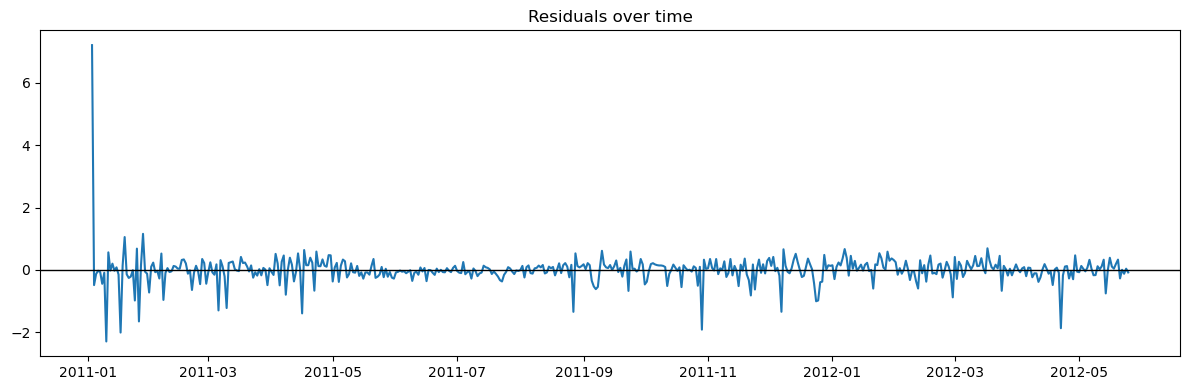

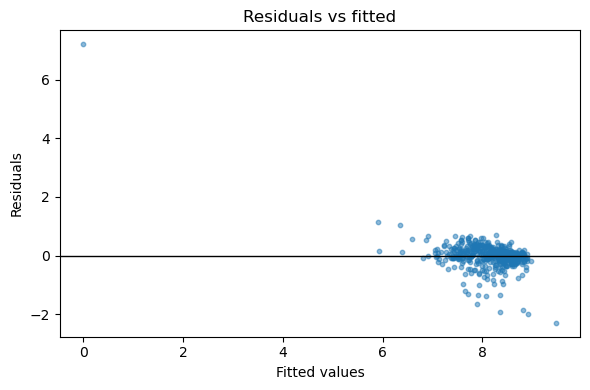

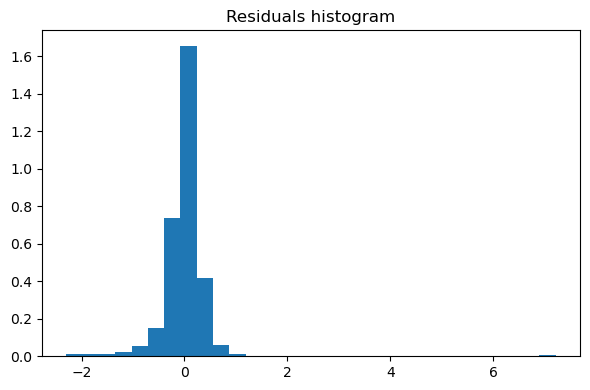

<Figure size 600x600 with 0 Axes>

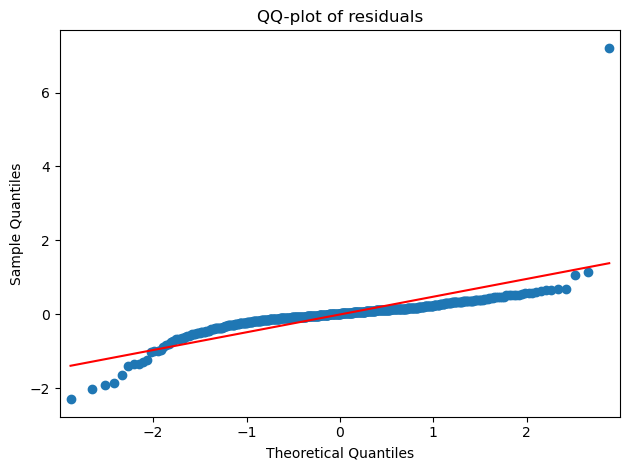

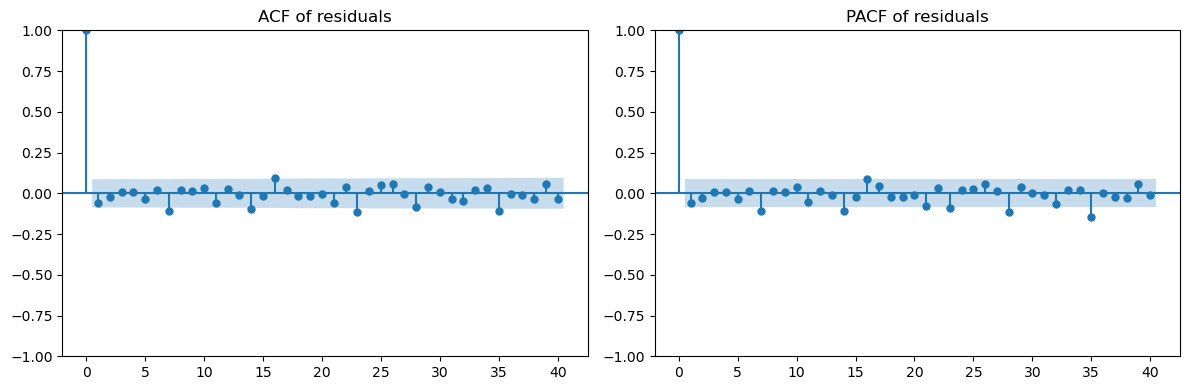

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# --- 3.1 Residuals over time ---
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuals over time")
plt.tight_layout()
plt.show()

# --- 3.2 Residuals vs fitted values ---
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, s=10, alpha=0.5)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.tight_layout()
plt.show()

# --- 3.3 Histogram of residuals ---
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30, density=True)
plt.title("Residuals histogram")
plt.tight_layout()
plt.show()

# --- 3.4 QQ plot for normality ---
plt.figure(figsize=(6,6))
qqplot(resid, line="s")
plt.title("QQ-plot of residuals")
plt.tight_layout()
plt.show()

# --- 3.5 ACF and PACF of residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(resid, lags=40, ax=axes[0])
axes[0].set_title("ACF of residuals")
plot_pacf(resid, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF of residuals")
plt.tight_layout()
plt.show()


## 7.Final Model SARIMA

In [ ]:
order          = tuple(best_lb_row["order"])
seasonal_order = tuple(best_lb_row["seasonal_order"])

mean_cv_rmse_sarima, fold_rmses_sarima, cv_pred_sarima = rolling_forecast_cv(
    y=y_trainval,           # log(cnt+1)
    cnt=cnt_trainval,       # original counts
    X=None,                 # no exog
    order=order,
    seasonal_order=seasonal_order,
    cv_splits=cv_splits,
    log_target=True,
)

print("Fold RMSEs (SARIMA):", fold_rmses_sarima)
print("Mean CV RMSE (SARIMA):", mean_cv_rmse_sarima)


Fold RMSEs (SARIMA): [993.0633840764899, 1056.3922946388889, 1173.2508970302058, 1227.0997282543935, 1660.448364361045]
Mean CV RMSE (SARIMA): 1222.0509336722046


In [ ]:
n_test = len(y_test)

# Forecast on test horizon
forecast_res = best_lb_model.get_forecast(steps=n_test)
y_test_pred_log = forecast_res.predicted_mean

# Back-transform from log to original count scale
y_test_pred = np.expm1(y_test_pred_log)

# True test values on original scale
y_test_true = cnt_test


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# y_trainval: log-transformed series on train+CV block
# y_test:      log-transformed series on test block
# cnt_trainval, cnt_test: original-scale series
chunk_size = 84
n_test = len(y_test)

all_pred_chunks = []
all_lower_chunks = []
all_upper_chunks = []

start = 0
fold = 1

while start < n_test:
    end = min(start + chunk_size, n_test)   # last chunk may be shorter
    h = end - start                         # forecast horizon for this chunk

    print(f"\nTest expanding fold {fold}: forecasting positions [{start}:{end}) in y_test")

    # Build expanding training set: trainval + all test data before 'start'
    y_train_exp = pd.concat([y_trainval, y_test.iloc[:start]])

    # Fit SARIMA on expanding training set (log scale)
    model_exp = SARIMAX(
        y_train_exp,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

    # Forecast h steps ahead
    forecast_res = model_exp.get_forecast(steps=h)
    mean_log = forecast_res.predicted_mean
    conf_int_log = forecast_res.conf_int(alpha=0.05)

    # Back-transform to original scale
    mean = np.expm1(mean_log)
    conf_int = np.expm1(conf_int_log)
    lower = conf_int.iloc[:, 0]
    upper = conf_int.iloc[:, 1]

    # Align indices with the corresponding part of cnt_test
    idx_chunk = cnt_test.iloc[start:end].index
    mean.index = idx_chunk
    lower.index = idx_chunk
    upper.index = idx_chunk

    all_pred_chunks.append(mean)
    all_lower_chunks.append(lower)
    all_upper_chunks.append(upper)

    start = end
    fold += 1

# Combine all chunks into full test-series predictions
y_test_pred_exp = pd.concat(all_pred_chunks).sort_index()
lower_pi_exp = pd.concat(all_lower_chunks).sort_index()
upper_pi_exp = pd.concat(all_upper_chunks).sort_index()

# Sanity: ensure indices match
y_test_pred_exp = y_test_pred_exp.loc[cnt_test.index]
lower_pi_exp   = lower_pi_exp.loc[cnt_test.index]
upper_pi_exp   = upper_pi_exp.loc[cnt_test.index]

# RMSE on full test block (expanding forecast, original scale)
mse_test_exp  = mean_squared_error(cnt_test, y_test_pred_exp)
rmse_test_exp = np.sqrt(mse_test_exp)
print("\nTest RMSE (expanding-window SARIMA, chunk size = {}): {:.3f}".format(chunk_size, rmse_test_exp))



Test expanding fold 1: forecasting positions [0:84) in y_test

Test expanding fold 2: forecasting positions [84:168) in y_test

Test expanding fold 3: forecasting positions [168:219) in y_test

Test RMSE (expanding-window SARIMA, chunk size = 84): 1793.733


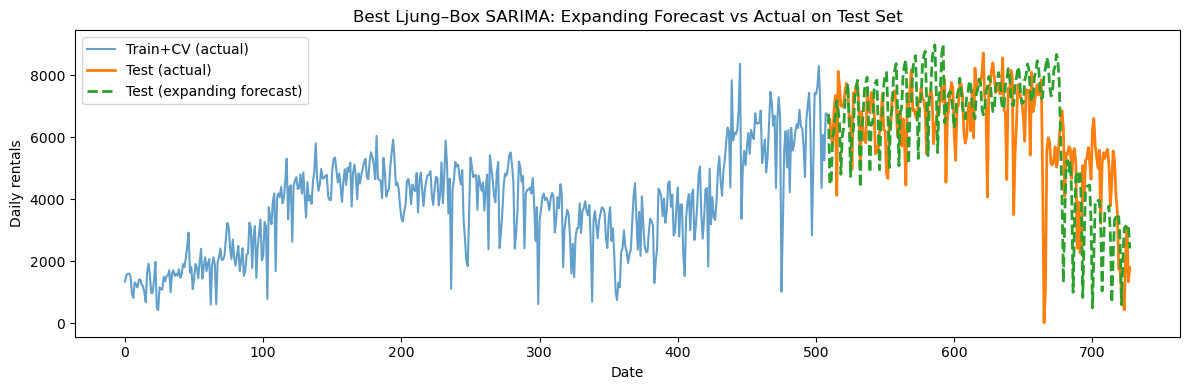

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Train+CV actual
plt.plot(cnt_trainval.index, cnt_trainval, label='Train+CV (actual)', alpha=0.7)

# Test actual
plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)

# Test forecasts (expanding)
plt.plot(cnt_test.index, y_test_pred_exp, label='Test (expanding forecast)', linestyle='--', linewidth=2)


plt.title('Best Ljung–Box SARIMA: Expanding Forecast vs Actual on Test Set')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


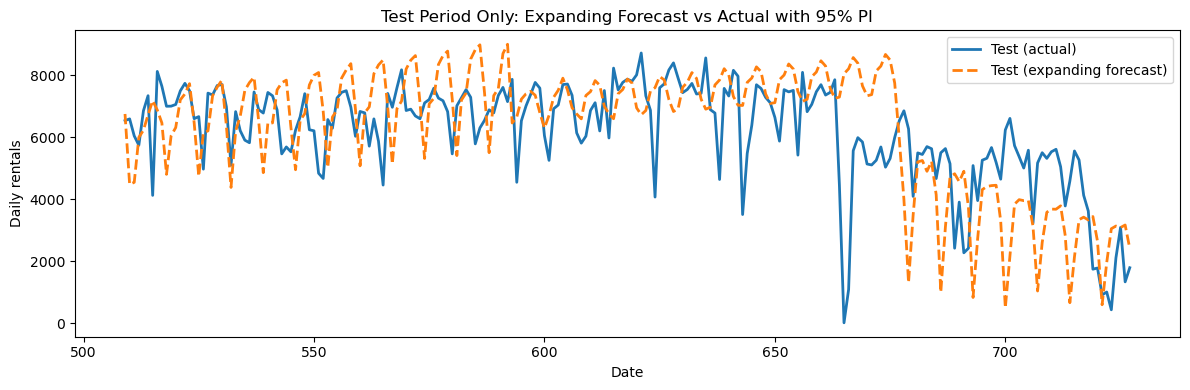

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)
plt.plot(cnt_test.index, y_test_pred_exp, label='Test (expanding forecast)', linestyle='--', linewidth=2)


plt.title('Test Period Only: Expanding Forecast vs Actual with 95% PI')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


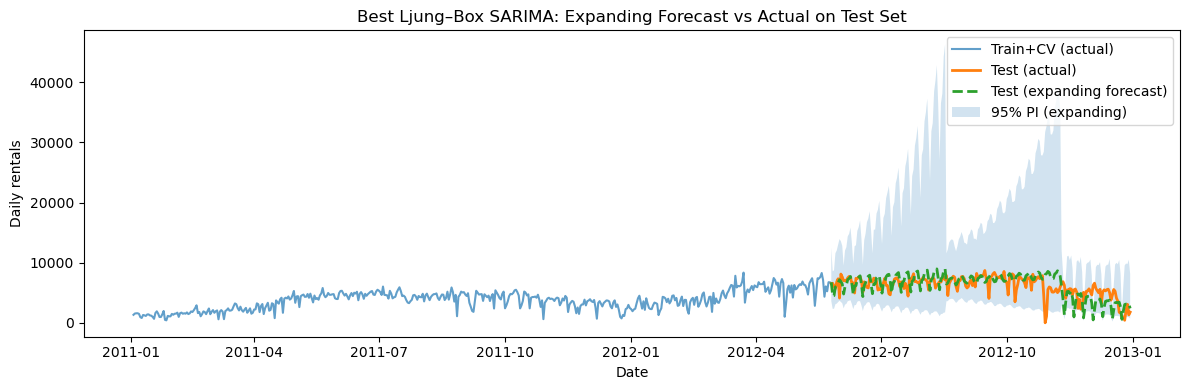

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Train+CV actual
plt.plot(cnt_trainval.index, cnt_trainval, label='Train+CV (actual)', alpha=0.7)

# Test actual
plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)

# Test forecasts (expanding)
plt.plot(cnt_test.index, y_test_pred_exp, label='Test (expanding forecast)', linestyle='--', linewidth=2)

# Expanding prediction interval
plt.fill_between(
    cnt_test.index,
    lower_pi_exp,
    upper_pi_exp,
    alpha=0.2,
    label='95% PI (expanding)'
)

plt.title('Best Ljung–Box SARIMA: Expanding Forecast vs Actual on Test Set')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


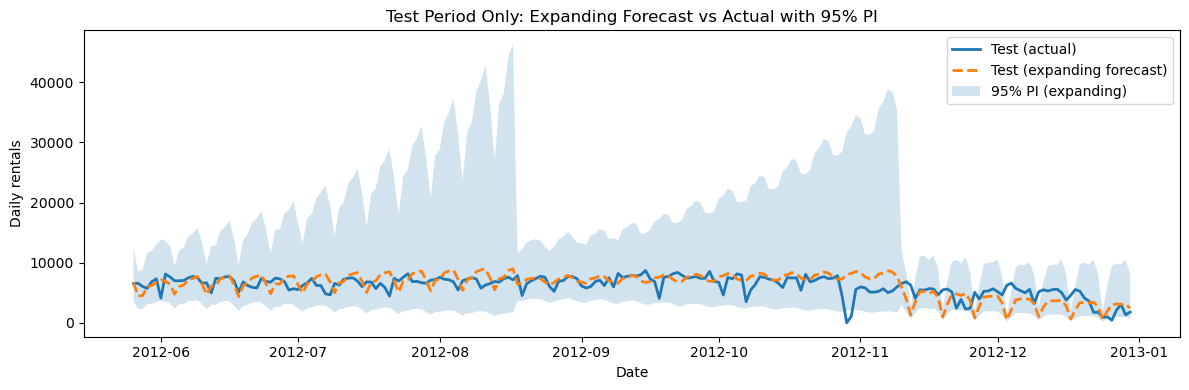

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)
plt.plot(cnt_test.index, y_test_pred_exp, label='Test (expanding forecast)', linestyle='--', linewidth=2)

plt.fill_between(
    cnt_test.index,
    lower_pi_exp,
    upper_pi_exp,
    alpha=0.2,
    label='95% PI (expanding)'
)

plt.title('Test Period Only: Expanding Forecast vs Actual with 95% PI')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


#Sarimax

##1.Prepareing

In [ ]:
# This is the same data as before, we (ผู้จัดทำ) was scared that the data will be tampered whilst coding so we decided to always download again
file_id = "1yESKCiY_PmrHn6S9kGkaEvnNWfowzL7K"
!gdown --id $file_id -O df_day.csv

import pandas as pd
df = pd.read_csv("df_day.csv")

## 2.โหลดและเตรียมข้อมูล

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import ray


In [ ]:
!pip -q install gdown
file_id = "1yESKCiY_PmrHn6S9kGkaEvnNWfowzL7K"
!gdown --id $file_id -O df_day.csv

import pandas as pd
df = pd.read_csv("df_day.csv")

C:\Users\Boonsoong\anaconda3\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yESKCiY_PmrHn6S9kGkaEvnNWfowzL7K
To: C:\Users\Boonsoong\df_day.csv

  0%|          | 0.00/118k [00:00<?, ?B/s]
100%|##########| 118k/118k [00:00<00:00, 1.11MB/s]
100%|##########| 118k/118k [00:00<00:00, 1.11MB/s]


In [ ]:
# Target
df['y_log'] = np.log1p(df['cnt'].astype(float))
y_all   = df['y_log']
cnt_all = df['cnt']

# Exogenous matrix
X_all = df[feature_cols].copy()

# Convert bool columns to int (0/1)
bool_cols = X_all.select_dtypes(include=['bool']).columns
X_all[bool_cols] = X_all[bool_cols].astype(int)

# (Optional) cast everything to float for safety
X_all = X_all.astype(float)

# Align everything, drop any rows with NaNs (e.g. from lags)
data = pd.concat([y_all, cnt_all, X_all], axis=1).dropna()

y_all   = data['y_log']
cnt_all = data['cnt']
X_all   = data[feature_cols]

print(y_all.shape, X_all.shape)

(728,) (728, 17)


## 3.Split data

In [ ]:
# Features that significantly Granger-cause y_log (p < 0.05)
significant_exog = gc_results.loc[gc_results['min_pvalue'] < 0.05, 'exog'].tolist()
print("Keeping these exogenous variables (p < 0.05):")
print(significant_exog)

# Reduced exogenous matrix
X_all_reduced = X_all[significant_exog]


Keeping these exogenous variables (p < 0.05):
['workingday', 'hum', 'windspeed', 'season_3', 'season_4', 'weather_3', 'weekday_prev', 'weekday_next', 'is_before_holiday', 'is_before_weekend', 'is_after_weekend', 'casual_lag1', 'registered_lag1', 'temp_mean']


In [ ]:
n_total = len(y_all)
trainval_size = int(n_total * 0.7)

y_trainval   = y_all.iloc[:trainval_size]
y_test       = y_all.iloc[trainval_size:]

cnt_trainval = cnt_all.iloc[:trainval_size]
cnt_test     = cnt_all.iloc[trainval_size:]

X_trainval   = X_all_reduced.iloc[:trainval_size]
X_test       = X_all_reduced.iloc[trainval_size:]

print("Train+CV range:", y_trainval.index.min(), "to", y_trainval.index.max())
print("Test range    :", y_test.index.min(),      "to", y_test.index.max())
print("Train+CV len  :", len(y_trainval), " Test len:", len(y_test))

Train+CV range: 0 to 508
Test range    : 509 to 727
Train+CV len  : 509  Test len: 219


In [ ]:
def make_expanding_splits(n_obs, n_splits=5):
    splits = []
    fold_size = n_obs // (n_splits + 1)
    for k in range(n_splits):
        train_end = fold_size * (k + 1) - 1
        val_start = train_end + 1
        val_end   = val_start + fold_size - 1
        if val_end >= n_obs:
            break
        splits.append((0, train_end, val_start, val_end))
    return splits

n_obs_trainval = len(y_trainval)
cv_splits = make_expanding_splits(n_obs_trainval, n_splits=5)

for s in cv_splits:
    print(s, "=> train_len", s[1]-s[0]+1, "val_len", s[3]-s[2]+1)


(0, 83, 84, 167) => train_len 84 val_len 84
(0, 167, 168, 251) => train_len 168 val_len 84
(0, 251, 252, 335) => train_len 252 val_len 84
(0, 335, 336, 419) => train_len 336 val_len 84
(0, 419, 420, 503) => train_len 420 val_len 84


In [ ]:
d, D, m = 1, 1, 7

p = q = range(0, 6)   # 0..6
P = Q = range(0, 6)   # 0..6

param_grid = []
for order in itertools.product(p, [d], q):
    for s_order in itertools.product(P, [D], Q, [m]):
        p_, _, q_     = order
        P_, _, Q_, _  = s_order

        param_grid.append((order, s_order))

print(f"Total candidate models: {len(param_grid)}")


Total candidate models: 1296


In [ ]:
ray.shutdown()
ray.init(num_cpus=64)  # or just ray.init()

(evaluate_sarima_cv_exog_remote pid=86784) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=85308) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
(evaluate_sarima_cv_exog_remote pid=85308)   warnings.warn("Maximum Likelihood optimization failed to "
2025-11-17 04:25:15,765	INFO worker.py:1788 -- Started a local Ray instance.


Python version:,3.12.4
Ray version:,2.32.0


## 4.Evaluate sarimax

In [ ]:
@ray.remote
def evaluate_sarima_cv_exog_remote(order, seasonal_order,
                                   y_array, cnt_array, X_array,
                                   cv_splits):
    try:
        y_array   = np.asarray(y_array,   dtype="float64")
        cnt_array = np.asarray(cnt_array, dtype="float64")
        X_array   = np.asarray(X_array,   dtype="float64")  # 2D

        rmses = []

        for (tr_start, tr_end, val_start, val_end) in cv_splits:
            endog_train = y_array[tr_start:tr_end+1]
            exog_train  = X_array[tr_start:tr_end+1, :]

            exog_val    = X_array[val_start:val_end+1, :]
            n_val       = val_end - val_start + 1

            model = SARIMAX(
                endog_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = model.fit(disp=False)

            forecast_res = results.get_forecast(steps=n_val, exog=exog_val)
            y_pred_log   = forecast_res.predicted_mean
            y_pred       = np.expm1(y_pred_log)

            cnt_true = cnt_array[val_start:val_end+1]
            mse  = mean_squared_error(cnt_true, y_pred)
            rmse = np.sqrt(mse)
            rmses.append(rmse)

        cv_rmse = float(np.mean(rmses))

        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "cv_rmse": cv_rmse,
            "error": None,
        }

    except Exception as e:
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "cv_rmse": np.inf,
            "error": str(e),
        }


In [ ]:
y_tv_array   = y_trainval.values
cnt_tv_array = cnt_trainval.values
X_tv_array   = X_trainval.values

futures = [
    evaluate_sarima_cv_exog_remote.remote(order, s_order,
                                          y_tv_array, cnt_tv_array, X_tv_array,
                                          cv_splits)
    for (order, s_order) in param_grid
]

results_list = []
num_completed = 0
total = len(futures)

while futures:
    done, futures = ray.wait(futures, num_returns=1)
    res = ray.get(done[0])
    results_list.append(res)
    num_completed += 1

    if num_completed % 50 == 0 or num_completed == total:
        ok_so_far = [r for r in results_list
                     if r["error"] is None and np.isfinite(r["cv_rmse"])]
        if ok_so_far:
            best_so_far = min(ok_so_far, key=lambda r: r["cv_rmse"])
            print(f"[Progress] {num_completed}/{total} models done. "
                  f"Best CV RMSE so far: {best_so_far['cv_rmse']:.3f} "
                  f"at {best_so_far['order']} x {best_so_far['seasonal_order']}")
        else:
            print(f"[Progress] {num_completed}/{total} models done, no valid models yet.")


(evaluate_sarima_cv_exog_remote pid=6336) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=6336)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=69384) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
(evaluate_sarima_cv_exog_remote pid=69384)   warnings.warn("Maximum Likelihood optimization failed to "
(evaluate_sarima_cv_exog_remote pid=98632) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=57060) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarni

[Progress] 50/1296 models done. Best CV RMSE so far: 2173.001 at (0, 1, 0) x (1, 1, 1, 7)


(evaluate_sarima_cv_exog_remote pid=45908) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=45908)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=94448) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=94448)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=64116) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for

[Progress] 100/1296 models done. Best CV RMSE so far: 2083.023 at (0, 1, 2) x (3, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=61760) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=61760)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=34024) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=34024)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=64216) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog

[Progress] 150/1296 models done. Best CV RMSE so far: 1715.580 at (0, 1, 3) x (3, 1, 1, 7)


(evaluate_sarima_cv_exog_remote pid=97996) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
(evaluate_sarima_cv_exog_remote pid=97996)   warnings.warn("Maximum Likelihood optimization failed to "
(evaluate_sarima_cv_exog_remote pid=98388) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=98388)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=42952) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_

[Progress] 200/1296 models done. Best CV RMSE so far: 1715.580 at (0, 1, 3) x (3, 1, 1, 7)


(evaluate_sarima_cv_exog_remote pid=98892) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=13392) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=13392)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=10776) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 12x across cluster]
(evaluate_sarima_cv_exog_remote pid=10776)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 12x across cluster]
(evaluate_sarima_cv_ex

[Progress] 250/1296 models done. Best CV RMSE so far: 1540.491 at (0, 1, 5) x (5, 1, 0, 7)


(evaluate_sarima_cv_exog_remote pid=23360) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=23360)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=94328) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=94328)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=10776) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for

[Progress] 300/1296 models done. Best CV RMSE so far: 1531.617 at (0, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=6336) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=90804) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=90804)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=81044) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 6x across cluster]
(evaluate_sarima_cv_exog_remote pid=81044)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 6x across cluster]
(evaluate_sarima_cv_exog_remote pid=100976) C:\Users\Boonsoong\AppData\Local\Temp\i

[Progress] 350/1296 models done. Best CV RMSE so far: 1531.617 at (0, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=62852) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 7x across cluster]
(evaluate_sarima_cv_exog_remote pid=62852)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 7x across cluster]
(evaluate_sarima_cv_exog_remote pid=54236) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=45356) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=45356)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_exog

[Progress] 400/1296 models done. Best CV RMSE so far: 1531.617 at (0, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=14772) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=81936) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=81936)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=64468) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=64468)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 3x across cluster]
(evaluate_sarima_cv_exog

[Progress] 450/1296 models done. Best CV RMSE so far: 1531.617 at (0, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=11960) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=11960)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=46168) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=46168)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=45252) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for

[Progress] 500/1296 models done. Best CV RMSE so far: 1530.571 at (1, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=64468) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=64468)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=45908) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=58996) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 6x across cluster]
(evaluate_sarima_cv_exog_remote pid=58996)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 6x across cluster]
(evaluate_sarima_cv_exog_remote pid=12984) C:\Users\Boonsoong\AppData\Local\Temp\i

[Progress] 550/1296 models done. Best CV RMSE so far: 1530.571 at (1, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=84700) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=81936) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=81936)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=81044) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=81044)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=93728) C:\Users\Boonsoong\anaconda3\Lib\site-p

[Progress] 600/1296 models done. Best CV RMSE so far: 1530.571 at (1, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=57060) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=57060)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=64116) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=64116)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=85328) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog

[Progress] 650/1296 models done. Best CV RMSE so far: 1530.571 at (1, 1, 5) x (5, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=41808) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=41808)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=48756) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=48756)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=15060) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog

[Progress] 700/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=45356) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=45356)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=94448) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=94448)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=98892) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to co

[Progress] 750/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=57060) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=57060)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=77840) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=77840)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=46168) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog

[Progress] 800/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=84700) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
(evaluate_sarima_cv_exog_remote pid=84700)   warn('Too few observations to estimate starting parameters%s.'
(evaluate_sarima_cv_exog_remote pid=13392) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=13392)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=54372) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=93728) C:\Users\Boonsoong\anaconda3\Lib\site-p

[Progress] 850/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=74852) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog_remote pid=72480) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=72480)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=74852) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=74852)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 3x across cluster]
(evaluate_sarima_cv_exog

[Progress] 900/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=54236) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=54236)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=94328) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1 [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=79388) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=79388)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 3x across clus

[Progress] 950/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=80184) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=80184)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=98388) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1 [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=98388) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=98388)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 5x across clus

[Progress] 1000/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=65420) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=65420)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=42952) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1 [repeated 6x across cluster]
(evaluate_sarima_cv_exog_remote pid=64216) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=64216)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 5x across clus

[Progress] 1050/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=81936) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=81936)   warn('Too few observations to estimate starting parameters%s.' [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=11960) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=11960)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=61772) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1
(evaluate_sarima_cv_exog

[Progress] 1100/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=78084) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=78084)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 5x across cluster]
(evaluate_sarima_cv_exog_remote pid=55992) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros. [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=55992)   warn('Too few observations to estimate starting parameters%s.' [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=55992) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1 [repeated 2x across clus

[Progress] 1150/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=94448) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1 [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=12984) C:\Users\Boonsoong\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:501: RuntimeWarning: overflow encountered in square
(evaluate_sarima_cv_exog_remote pid=12984)   output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
(evaluate_sarima_cv_exog_remote pid=85328) C:\Users\Boonsoong\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:501: RuntimeWarning: overflow encountered in square
(evaluate_sarima_cv_exog_remote pid=85328)   output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
(evaluate_sarima_cv_exog_remote pid=69748) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

[Progress] 1200/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=31532) C:\Users\Boonsoong\AppData\Local\Temp\ipykernel_38752\2645579350.py:31: RuntimeWarning: overflow encountered in expm1 [repeated 6x across cluster]
(evaluate_sarima_cv_exog_remote pid=27612) C:\Users\Boonsoong\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:501: RuntimeWarning: overflow encountered in square [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=27612)   output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight) [repeated 2x across cluster]
(evaluate_sarima_cv_exog_remote pid=50612) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=50612)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 3x across cluster]
(evaluate_sarima_cv_exog_remote pid=69748) C:\Users\Boonsoong\anaconda3\Lib\sit

[Progress] 1250/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


(evaluate_sarima_cv_exog_remote pid=57060) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=57060)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=61760) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=61760)   warnings.warn("Maximum Likelihood optimization failed to " [repeated 4x across cluster]
(evaluate_sarima_cv_exog_remote pid=69384) C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals [repeated 5x across cluster]
(evaluate_sari

[Progress] 1296/1296 models done. Best CV RMSE so far: 1528.888 at (2, 1, 5) x (4, 1, 2, 7)


## 5.Top 10 models by RMSE

In [ ]:
results_table = pd.DataFrame(results_list)

ok = results_table[
    (results_table['error'].isna()) &
    np.isfinite(results_table['cv_rmse'])
].copy()

ok = ok.sort_values("cv_rmse")

print("\nTop 10 models by CV RMSE on 70% block:")
print(ok.head(10))

best_row = ok.iloc[0]
best_order    = tuple(best_row['order'])
best_s_order  = tuple(best_row['seasonal_order'])
best_cv_rmse  = best_row['cv_rmse']

print("\n=== Best model by expanding-window CV RMSE (on 70%) ===")
print("Order         :", best_order)
print("Seasonal order:", best_s_order)
print("CV RMSE       :", best_cv_rmse)



Top 10 models by CV RMSE on 70% block:
          order seasonal_order      cv_rmse error
670   (2, 1, 5)   (4, 1, 2, 7)  1528.887999  None
486   (1, 1, 5)   (5, 1, 2, 7)  1530.570671  None
277   (0, 1, 5)   (5, 1, 2, 7)  1531.617278  None
752   (2, 1, 5)   (5, 1, 2, 7)  1539.433416  None
243   (0, 1, 5)   (5, 1, 0, 7)  1540.491367  None
239   (0, 1, 5)   (4, 1, 2, 7)  1569.629908  None
258   (0, 1, 5)   (5, 1, 1, 7)  1572.555227  None
470   (1, 1, 5)   (5, 1, 0, 7)  1573.985150  None
1054  (4, 1, 4)   (4, 1, 2, 7)  1585.702240  None
688   (2, 1, 5)   (5, 1, 0, 7)  1588.285647  None

=== Best model by expanding-window CV RMSE (on 70%) ===
Order         : (2, 1, 5)
Seasonal order: (4, 1, 2, 7)
CV RMSE       : 1528.8879985645444


## 6.Ljung-Box table

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Sort by RMSE (or cv_rmse)
ok_sorted = ok.sort_values("cv_rmse").reset_index(drop=True)

best_lb_row = None
best_lb_model = None
best_lb_lb = None  # store ljung-box table

for i, row in ok_sorted.iterrows():
    order = tuple(row["order"])
    seasonal_order = tuple(row["seasonal_order"])
    print(f"Trying Ljung-Box for model {i+1}: order={order}, seasonal={seasonal_order}")

    try:
        model = SARIMAX(
            y_trainval,
            exog=X_trainval,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)

        resid = results.resid.dropna()

        # Ljung-Box at lags 7, 14, 21
        lb = acorr_ljungbox(resid, lags=[7, 14, 21], return_df=True)

        # require ALL tested lags to have p-value > 0.05
        if (lb["lb_pvalue"] > 0.05).all():
            best_lb_row = row
            best_lb_model = results
            best_lb_lb = lb
            print(">> This model PASSES Ljung-Box at all lags (7, 14, 21).")
            break
        else:
            print("   Fails Ljung-Box (some p-values <= 0.05).")

    except Exception as e:
        print(f"   Fitting failed for this model: {e}")
        continue

if best_lb_model is not None:
    print("\n=== First model (by RMSE) that passes Ljung-Box ===")
    print("Order         :", tuple(best_lb_row["order"]))
    print("Seasonal order:", tuple(best_lb_row["seasonal_order"]))
    print("CV RMSE       :", best_lb_row["cv_rmse"])
    print("\nLjung-Box table:")
    print(best_lb_lb)
else:
    print("\nNo model in 'ok' passed Ljung-Box at all chosen lags (7, 14, 21).")


Trying Ljung-Box for model 1: order=(2, 1, 5), seasonal=(4, 1, 2, 7)
   Fails Ljung-Box (some p-values <= 0.05).
Trying Ljung-Box for model 2: order=(1, 1, 5), seasonal=(5, 1, 2, 7)
>> This model PASSES Ljung-Box at all lags (7, 14, 21).

=== First model (by RMSE) that passes Ljung-Box ===
Order         : (1, 1, 5)
Seasonal order: (5, 1, 2, 7)
CV RMSE       : 1530.570671039207

Ljung-Box table:
      lb_stat  lb_pvalue
7   13.831884   0.054254
14  18.463450   0.186481
21  22.782337   0.355693


## 7.(Initial) SARIMAX Results

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Only if best_lb_model is NOT already defined:
order = tuple(best_lb_row["order"])
seasonal_order = tuple(best_lb_row["seasonal_order"])

best_lb_model = SARIMAX(
    y_trainval,# log-transformed series on the 70% train+CV block
    exog=X_trainval,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(best_lb_model.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                  y_log   No. Observations:                  509
Model:             SARIMAX(1, 1, 5)x(5, 1, [1, 2], 7)   Log Likelihood                 -20.103
Date:                                Mon, 17 Nov 2025   AIC                             96.207
Time:                                        04:45:19   BIC                            212.184
Sample:                                             0   HQIC                           141.855
                                                - 509                                         
Covariance Type:                                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
workingday            0.0302      0.115      0.262      0.793      -

## 8.Backward Selection SARIMAX with exog

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd

def backward_elimination_sarimax(
    y, X, order, seasonal_order, p_threshold=0.05, verbose=True,
    enforce_stationarity=False, enforce_invertibility=False
):
    """
    Backward elimination on exogenous variables using SARIMAX p-values.

    Parameters
    ----------
    y : pandas Series
        Target series (e.g. y_trainval, log-transformed).
    X : pandas DataFrame
        Exogenous variables (same index as y).
    order : tuple
        (p, d, q) for SARIMAX.
    seasonal_order : tuple
        (P, D, Q, m) for SARIMAX.
    p_threshold : float
        Significance level for keeping variables (default 0.05).
    verbose : bool
        Print progress if True.

    Returns
    -------
    final_results : statsmodels SARIMAXResults
        Fitted model with the selected exogenous variables.
    selected_exog : list
        List of retained exogenous variable names.
    elimination_history : list of (var, pvalue)
        Variables removed and their p-values at the time of removal.
    """
    # Ensure aligned and no NaNs
    y = y.astype(float)
    X = X.astype(float)
    y, X = y.align(X, join='inner', axis=0)
    X = X.copy()

    current_exog = list(X.columns)
    elimination_history = []

    while True:
        if len(current_exog) == 0:
            if verbose:
                print("No exogenous variables left; stopping.")
            # Fit model with no exog at all
            model = SARIMAX(
                y,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=enforce_stationarity,
                enforce_invertibility=enforce_invertibility,
            )
            results = model.fit(disp=False)
            return results, [], elimination_history

        X_curr = X[current_exog]

        if verbose:
            print("\nFitting SARIMAX with exog:", current_exog)

        model = SARIMAX(
            y,
            exog=X_curr,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=enforce_stationarity,
            enforce_invertibility=enforce_invertibility,
        )
        results = model.fit(disp=False)

        # Get p-values and focus only on exogenous coefficients
        pvalues = results.pvalues

        # Intersect pvalues index with the current exog names
        exog_pvalues = pvalues.loc[[name for name in current_exog if name in pvalues.index]]

        if exog_pvalues.empty:
            if verbose:
                print("No exogenous p-values found (maybe collinearity?). Stopping.")
            return results, current_exog, elimination_history

        # Find worst (largest) p-value among exog
        worst_var = exog_pvalues.idxmax()
        worst_p = exog_pvalues.max()

        if verbose:
            print("Exog p-values:")
            print(exog_pvalues.sort_values())
            print(f"Worst exog: {worst_var}, p = {worst_p:.4f}")

        # If all exog are significant enough, stop
        if worst_p <= p_threshold:
            if verbose:
                print(f"All remaining exog have p <= {p_threshold}. Stopping.")
            break

        # Otherwise drop the worst and refit
        elimination_history.append((worst_var, worst_p))
        current_exog.remove(worst_var)

        if verbose:
            print(f"Removing '{worst_var}' (p = {worst_p:.4f}) and refitting...")

    return results, current_exog, elimination_history


In [ ]:
order = (1, 1, 5)
seasonal_order = (5, 1, 2, 7)

# X_trainval should be your exogenous DataFrame (70% block),
# y_trainval your log-transformed target on the same 70%.

final_results, selected_exog, elimination_history = backward_elimination_sarimax(
    y=y_trainval,
    X=X_trainval,
    order=order,
    seasonal_order=seasonal_order,
    p_threshold=0.05,            # you can use 0.1 if you want to be more lenient
    verbose=True,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

print("\nSelected exogenous variables:")
print(selected_exog)

print("\nElimination history (dropped variable, p-value at time of drop):")
for var, p in elimination_history:
    print(f"{var:20s}  p = {p:.4f}")



Fitting SARIMAX with exog: ['workingday', 'hum', 'windspeed', 'season_3', 'season_4', 'weather_3', 'weekday_prev', 'weekday_next', 'is_before_holiday', 'is_before_weekend', 'is_after_weekend', 'casual_lag1', 'registered_lag1', 'temp_mean']
Exog p-values:
weather_3            1.723416e-23
hum                  1.338429e-12
temp_mean            2.101779e-07
windspeed            4.113058e-03
season_3             7.229796e-02
registered_lag1      1.857461e-01
casual_lag1          2.001025e-01
is_before_holiday    5.697943e-01
workingday           7.929508e-01
season_4             9.979652e-01
weekday_next         1.000000e+00
is_after_weekend     1.000000e+00
is_before_weekend    1.000000e+00
weekday_prev         1.000000e+00
dtype: float64
Worst exog: weekday_prev, p = 1.0000
Removing 'weekday_prev' (p = 1.0000) and refitting...

Fitting SARIMAX with exog: ['workingday', 'hum', 'windspeed', 'season_3', 'season_4', 'weather_3', 'weekday_next', 'is_before_holiday', 'is_before_weekend', 'is_

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Restrict X to the selected exogenous variables
X_trainval_sel = X_trainval[selected_exog]

def cv_rmse_for_final_sarimax(y_trainval, cnt_trainval, X_trainval_sel,
                              order, seasonal_order, cv_splits):
    """
    Compute expanding-window CV RMSE for a fixed SARIMAX model
    with a fixed set of exogenous variables.
    """
    y_array   = np.asarray(y_trainval,   dtype="float64")
    cnt_array = np.asarray(cnt_trainval, dtype="float64")
    X_array   = np.asarray(X_trainval_sel, dtype="float64")  # 2D: (T, k)

    rmses = []

    for (tr_start, tr_end, val_start, val_end) in cv_splits:
        # Training subset
        endog_train = y_array[tr_start:tr_end+1]
        exog_train  = X_array[tr_start:tr_end+1, :]

        # Validation subset (only exog + true counts needed)
        exog_val = X_array[val_start:val_end+1, :]
        n_val    = val_end - val_start + 1

        # Fit model on this fold
        model = SARIMAX(
            endog_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)

        # Forecast into validation window
        forecast_res = results.get_forecast(steps=n_val, exog=exog_val)
        y_pred_log   = forecast_res.predicted_mean
        y_pred       = np.expm1(y_pred_log)  # back to counts

        cnt_true = cnt_array[val_start:val_end+1]
        mse  = mean_squared_error(cnt_true, y_pred)
        rmse = np.sqrt(mse)
        rmses.append(rmse)

    return float(np.mean(rmses)), rmses

cv_rmse_final, fold_rmses = cv_rmse_for_final_sarimax(
    y_trainval, cnt_trainval, X_trainval_sel,
    order, seasonal_order, cv_splits
)

print("Fold RMSEs (final SARIMAX+exog):", fold_rmses)
print("Mean CV RMSE (final SARIMAX+exog):", cv_rmse_final)


C:\Users\Boonsoong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold RMSEs (final SARIMAX+exog): [1045.5587018954532, 1135.603606461737, 2018.681161733338, 941.0671054555683, 1271.433426186815]
Mean CV RMSE (final SARIMAX+exog): 1282.4688003465824


## 9.Final model SARIMAX

In [ ]:
# Make sure X_test has the same selected exog columns
X_test_sel = X_test[selected_exog]

# Refit final model on full train+CV block
final_model = SARIMAX(
    y_trainval,
    exog=X_trainval_sel,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(final_model.summary())

# Forecast on test (30%)
n_test = len(y_test)
forecast_res = final_model.get_forecast(steps=n_test, exog=X_test_sel)
y_test_pred_log = forecast_res.predicted_mean
y_test_pred = np.expm1(y_test_pred_log)

mse_test  = mean_squared_error(cnt_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print("Test RMSE (final SARIMAX+exog, after CV selection):", rmse_test)


                                       SARIMAX Results                                        
Dep. Variable:                                  y_log   No. Observations:                  509
Model:             SARIMAX(1, 1, 5)x(5, 1, [1, 2], 7)   Log Likelihood                  16.099
Date:                                Thu, 20 Nov 2025   AIC                              7.803
Time:                                        20:36:41   BIC                             90.643
Sample:                                             0   HQIC                            40.409
                                                - 509                                         
Covariance Type:                                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
hum                -0.9522      0.073    -13.087      0.000      -1.095 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

resid = final_model.resid.dropna()
fitted = final_model.fittedvalues.loc[resid.index]


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[7, 14, 21, 28], return_df=True)
print("Ljung–Box test on residuals:")
print(lb)
print("\nInterpretation: p-values > 0.05 => no evidence of residual autocorrelation up to that lag.")


Ljung–Box test on residuals:
      lb_stat  lb_pvalue
7   13.734485   0.056110
14  19.852107   0.134874
21  24.159037   0.285417
28  33.200128   0.228453

Interpretation: p-values > 0.05 => no evidence of residual autocorrelation up to that lag.


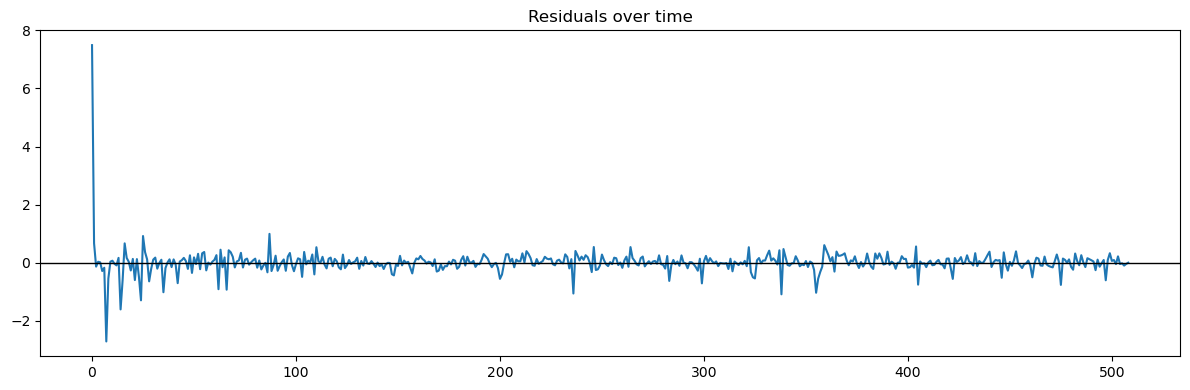

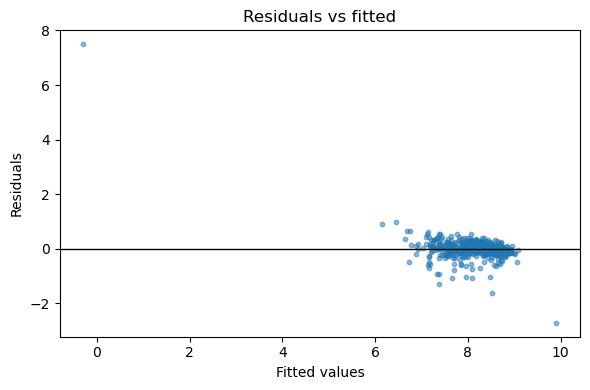

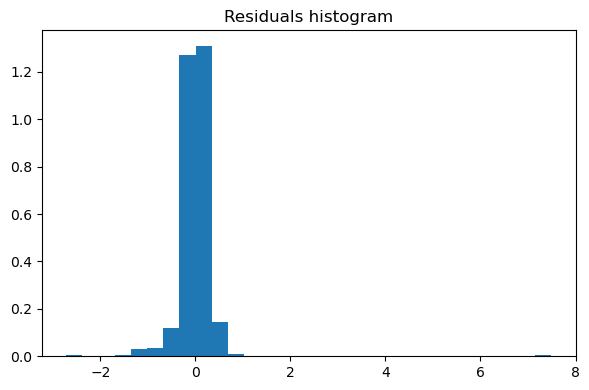

<Figure size 600x600 with 0 Axes>

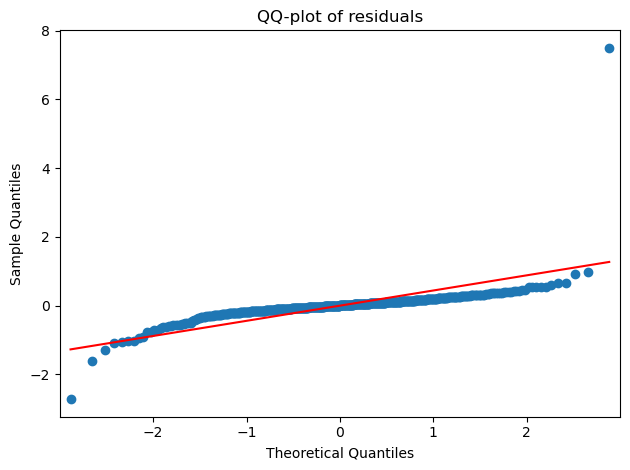

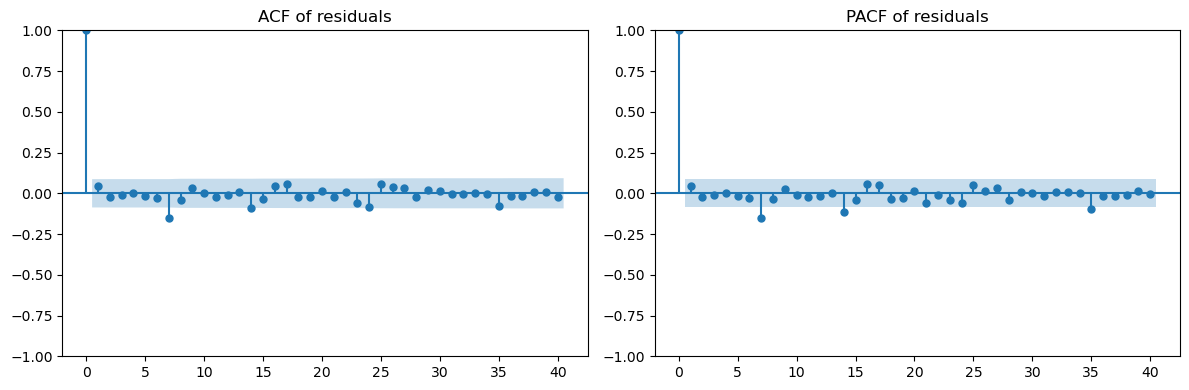

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# --- 3.1 Residuals over time ---
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuals over time")
plt.tight_layout()
plt.show()

# --- 3.2 Residuals vs fitted values ---
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, s=10, alpha=0.5)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.tight_layout()
plt.show()

# --- 3.3 Histogram of residuals ---
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30, density=True)
plt.title("Residuals histogram")
plt.tight_layout()
plt.show()

# --- 3.4 QQ plot for normality ---
plt.figure(figsize=(6,6))
qqplot(resid, line="s")
plt.title("QQ-plot of residuals")
plt.tight_layout()
plt.show()

# --- 3.5 ACF and PACF of residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(resid, lags=40, ax=axes[0])
axes[0].set_title("ACF of residuals")
plot_pacf(resid, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF of residuals")
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

n_test = len(y_test)

all_pred_chunks  = []
all_lower_chunks = []
all_upper_chunks = []

chunk_size = 84
start = 0
fold  = 1

while start < n_test:
    end = min(start + chunk_size, n_test)   # last chunk may be shorter
    h   = end - start                       # horizon for this chunk

    print(f"\nSARIMAX test expanding fold {fold}: forecasting positions [{start}:{end}) in y_test")

    # Build expanding training sets (log scale for y, raw scale for X)
    y_train_exp = pd.concat([y_trainval,     y_test.iloc[:start]])
    X_train_exp = pd.concat([X_trainval_sel, X_test_sel.iloc[:start]])

    # Exog for this future chunk
    X_chunk_future = X_test_sel.iloc[start:end]

    # Fit SARIMAX on expanding train block
    model_exp = SARIMAX(
        y_train_exp,
        exog=X_train_exp,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

    # Forecast h steps ahead with exog for that chunk
    forecast_res = model_exp.get_forecast(steps=h, exog=X_chunk_future)

    # Mean forecast on log scale
    mean_log = forecast_res.predicted_mean
    # 95% PI on log scale
    conf_int_log = forecast_res.conf_int(alpha=0.05)

    # Back-transform to original rental count scale
    mean    = np.expm1(mean_log)
    conf_int = np.expm1(conf_int_log)
    lower   = conf_int.iloc[:, 0]
    upper   = conf_int.iloc[:, 1]

    # Align with the corresponding piece of cnt_test
    idx_chunk = cnt_test.iloc[start:end].index
    mean.index  = idx_chunk
    lower.index = idx_chunk
    upper.index = idx_chunk

    all_pred_chunks.append(mean)
    all_lower_chunks.append(lower)
    all_upper_chunks.append(upper)

    start += h
    fold  += 1

# Stitch chunks into full test forecasts
y_test_pred_exp_exog = pd.concat(all_pred_chunks).sort_index()
lower_pi_exp_exog    = pd.concat(all_lower_chunks).sort_index()
upper_pi_exp_exog    = pd.concat(all_upper_chunks).sort_index()

# Make sure they line up with cnt_test exactly
y_test_pred_exp_exog = y_test_pred_exp_exog.loc[cnt_test.index]
lower_pi_exp_exog    = lower_pi_exp_exog.loc[cnt_test.index]
upper_pi_exp_exog    = upper_pi_exp_exog.loc[cnt_test.index]

# RMSE on full test block (expanding-window SARIMAX)
mse_test_exp_exog  = mean_squared_error(cnt_test, y_test_pred_exp_exog)
rmse_test_exp_exog = np.sqrt(mse_test_exp_exog)
print("\nTest RMSE (expanding-window SARIMAX+exog, chunk size = {}): {:.3f}".format(
    chunk_size, rmse_test_exp_exog
))



SARIMAX test expanding fold 1: forecasting positions [0:84) in y_test

SARIMAX test expanding fold 2: forecasting positions [84:168) in y_test

SARIMAX test expanding fold 3: forecasting positions [168:219) in y_test

Test RMSE (expanding-window SARIMAX+exog, chunk size = 84): 3247.657


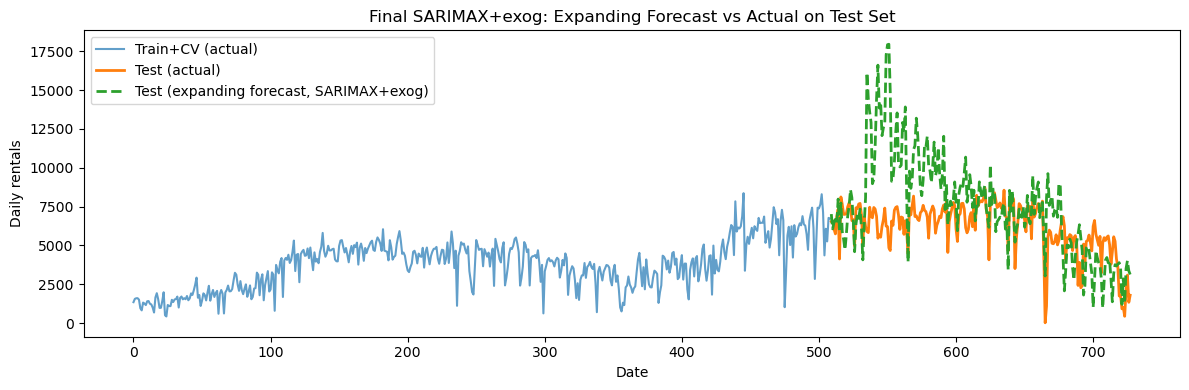

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Train+CV actual
plt.plot(cnt_trainval.index, cnt_trainval, label='Train+CV (actual)', alpha=0.7)

# Test actual
plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)

# Test expanding forecast (SARIMAX)
plt.plot(
    cnt_test.index,
    y_test_pred_exp_exog,
    label='Test (expanding forecast, SARIMAX+exog)',
    linestyle='--',
    linewidth=2,
)

plt.title('Final SARIMAX+exog: Expanding Forecast vs Actual on Test Set')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


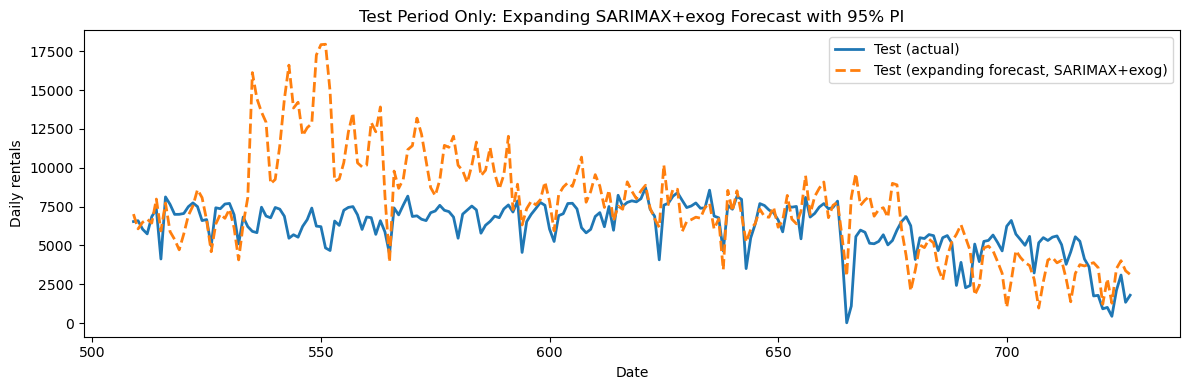

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)
plt.plot(
    cnt_test.index,
    y_test_pred_exp_exog,
    label='Test (expanding forecast, SARIMAX+exog)',
    linestyle='--',
    linewidth=2,
)

plt.title('Test Period Only: Expanding SARIMAX+exog Forecast with 95% PI')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


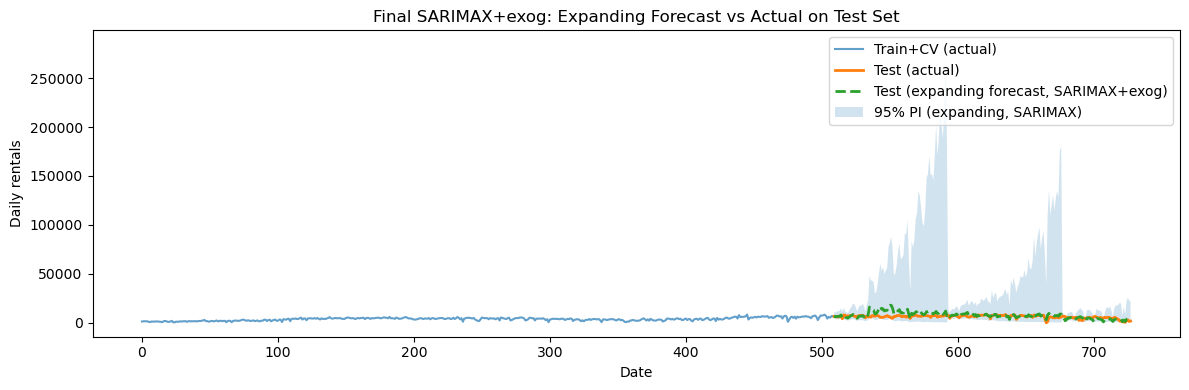

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Train+CV actual
plt.plot(cnt_trainval.index, cnt_trainval, label='Train+CV (actual)', alpha=0.7)

# Test actual
plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)

# Test expanding forecast (SARIMAX)
plt.plot(
    cnt_test.index,
    y_test_pred_exp_exog,
    label='Test (expanding forecast, SARIMAX+exog)',
    linestyle='--',
    linewidth=2,
)

# Prediction interval band
plt.fill_between(
    cnt_test.index,
    lower_pi_exp_exog,
    upper_pi_exp_exog,
    alpha=0.2,
    label='95% PI (expanding, SARIMAX)'
)

plt.title('Final SARIMAX+exog: Expanding Forecast vs Actual on Test Set')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


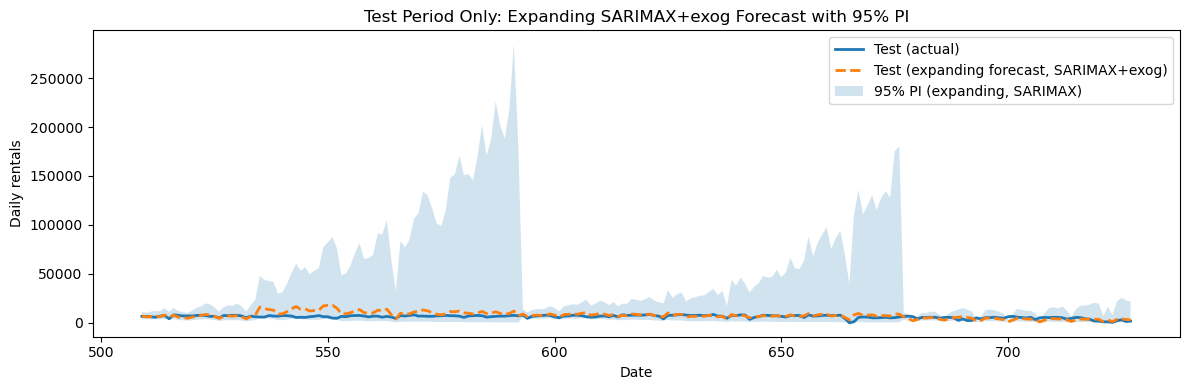

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(cnt_test.index, cnt_test, label='Test (actual)', linewidth=2)
plt.plot(
    cnt_test.index,
    y_test_pred_exp_exog,
    label='Test (expanding forecast, SARIMAX+exog)',
    linestyle='--',
    linewidth=2,
)

plt.fill_between(
    cnt_test.index,
    lower_pi_exp_exog,
    upper_pi_exp_exog,
    alpha=0.2,
    label='95% PI (expanding, SARIMAX)'
)

plt.title('Test Period Only: Expanding SARIMAX+exog Forecast with 95% PI')
plt.xlabel('Date')
plt.ylabel('Daily rentals')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
ray.shutdown()

# SUMMARY

Comparing the performance of the SARIMA and SARIMAX models on this dataset, the SARIMA model appears to be better.

Here's a summary of the results:

SARIMA Model (without exogenous variables):



*    **Best CV RMSE: 1222.051**




SARIMAX Model (with selected exogenous variables):



*   Best CV RMSE (after backward elimination): 1282.469







The SARIMA model achieved a lower 5-Fold CV RMSE (1222.051) compared to the SARIMAX model (1282.469), thus we select SARIMA model as our main model.